## Fret Frequency Plot

In [1]:
import sys
sys.path.append("../scripts")
from filter_by_tuning import *
from constants import TUNING_LABELS
import pandas as pd

In [2]:
# Load and filter data by tuning
drop_d = load_analysis_file_by_tuning(filepath="analysis_results.json", tuning_label="Drop D")
open_d = load_analysis_file_by_tuning(filepath="analysis_results.json", tuning_label="Open D")
standard = load_analysis_file_by_tuning(filepath="analysis_results.json", tuning_label="Standard")
drop_c = load_analysis_file_by_tuning(filepath="analysis_results.json", tuning_label="Drop C")

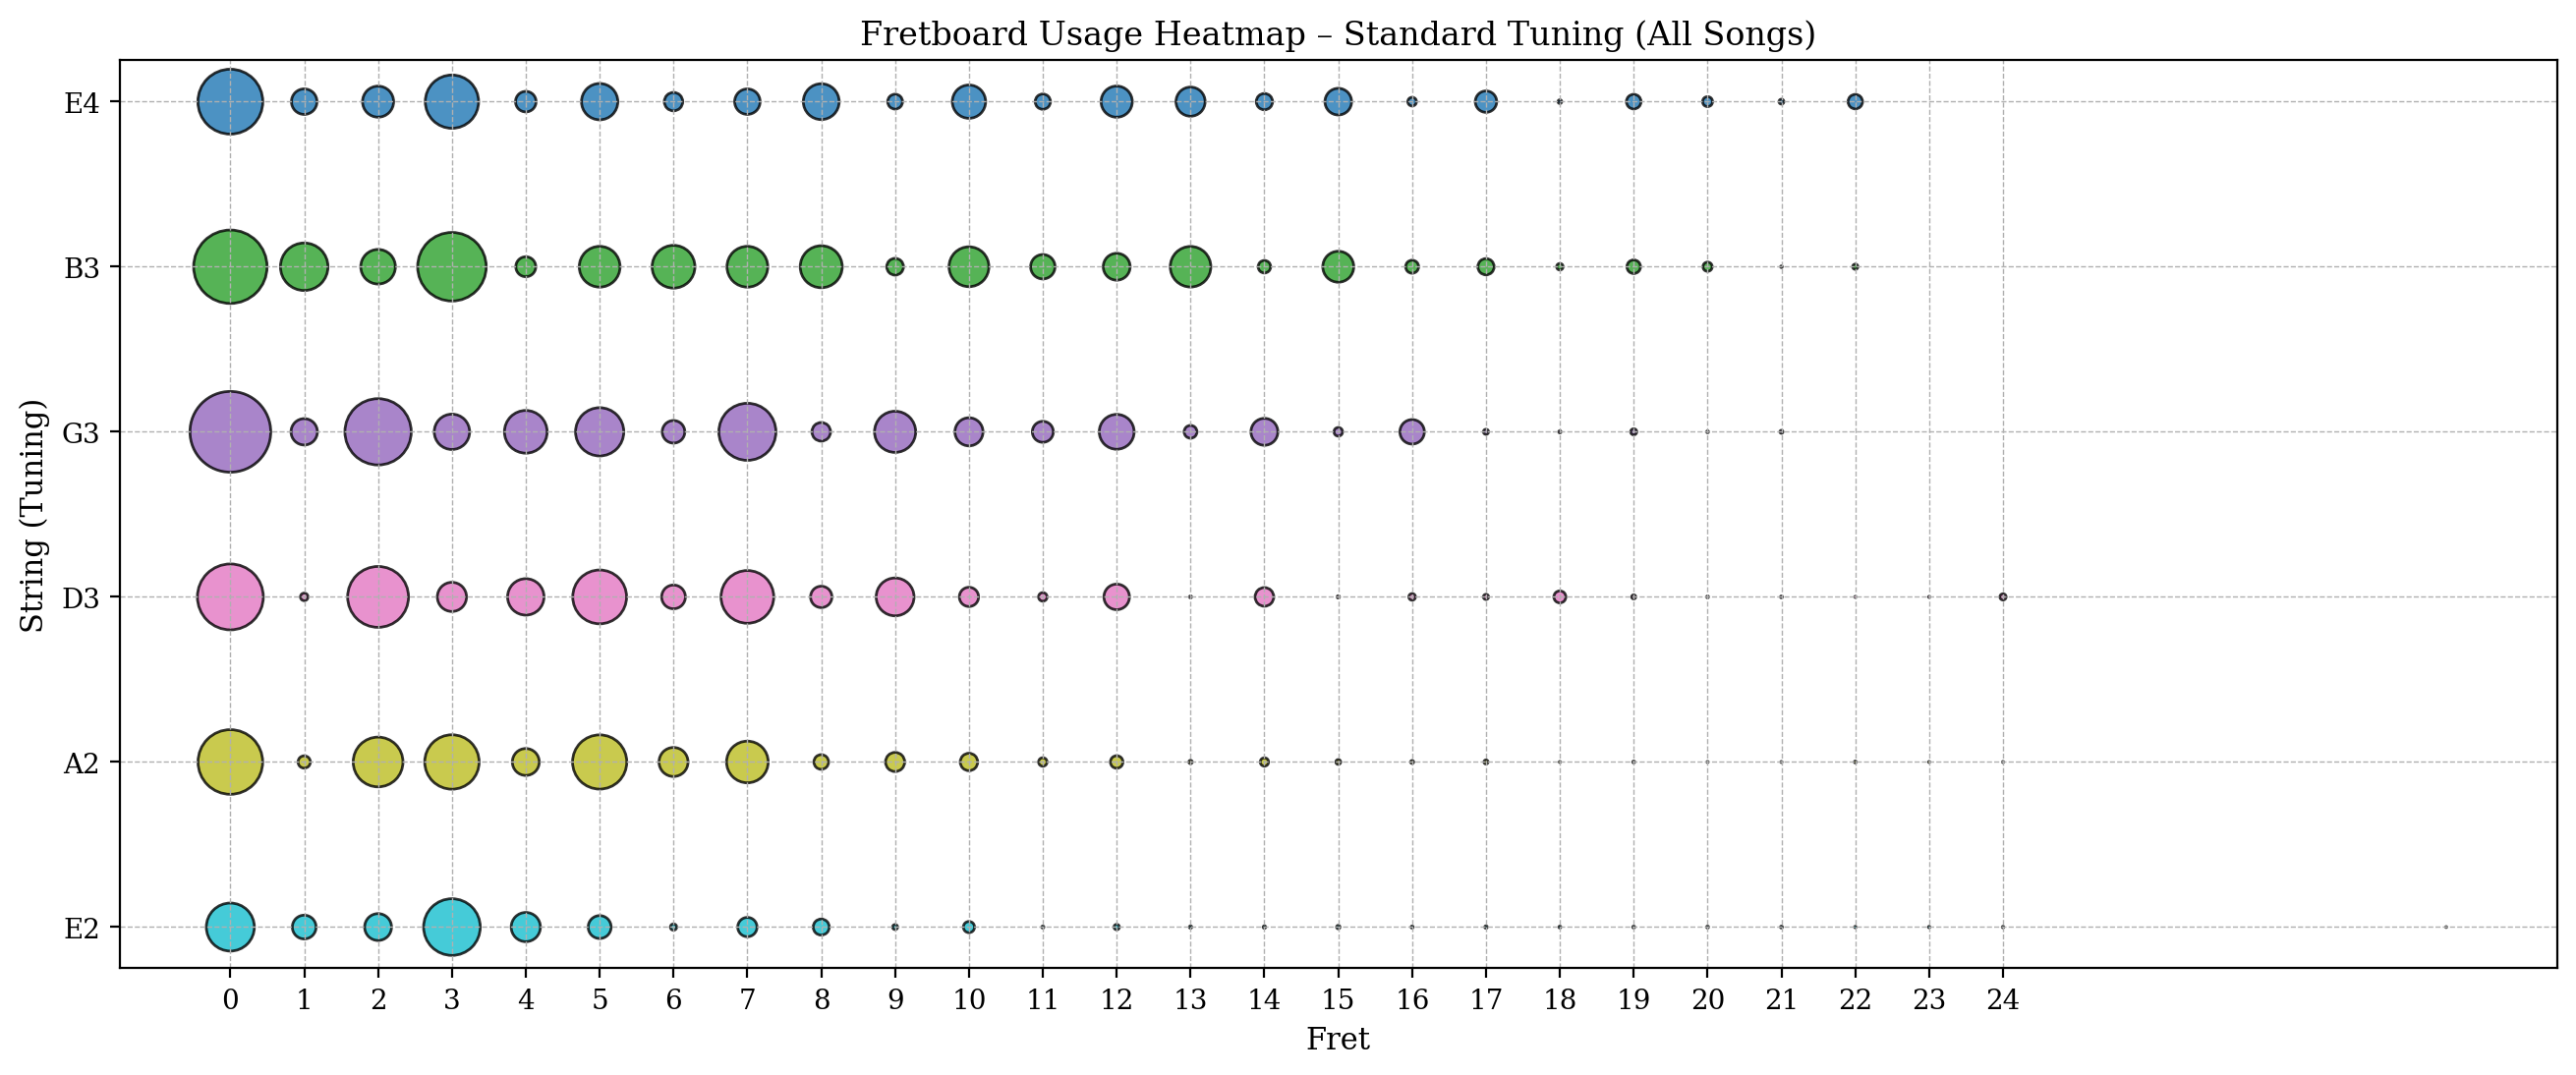

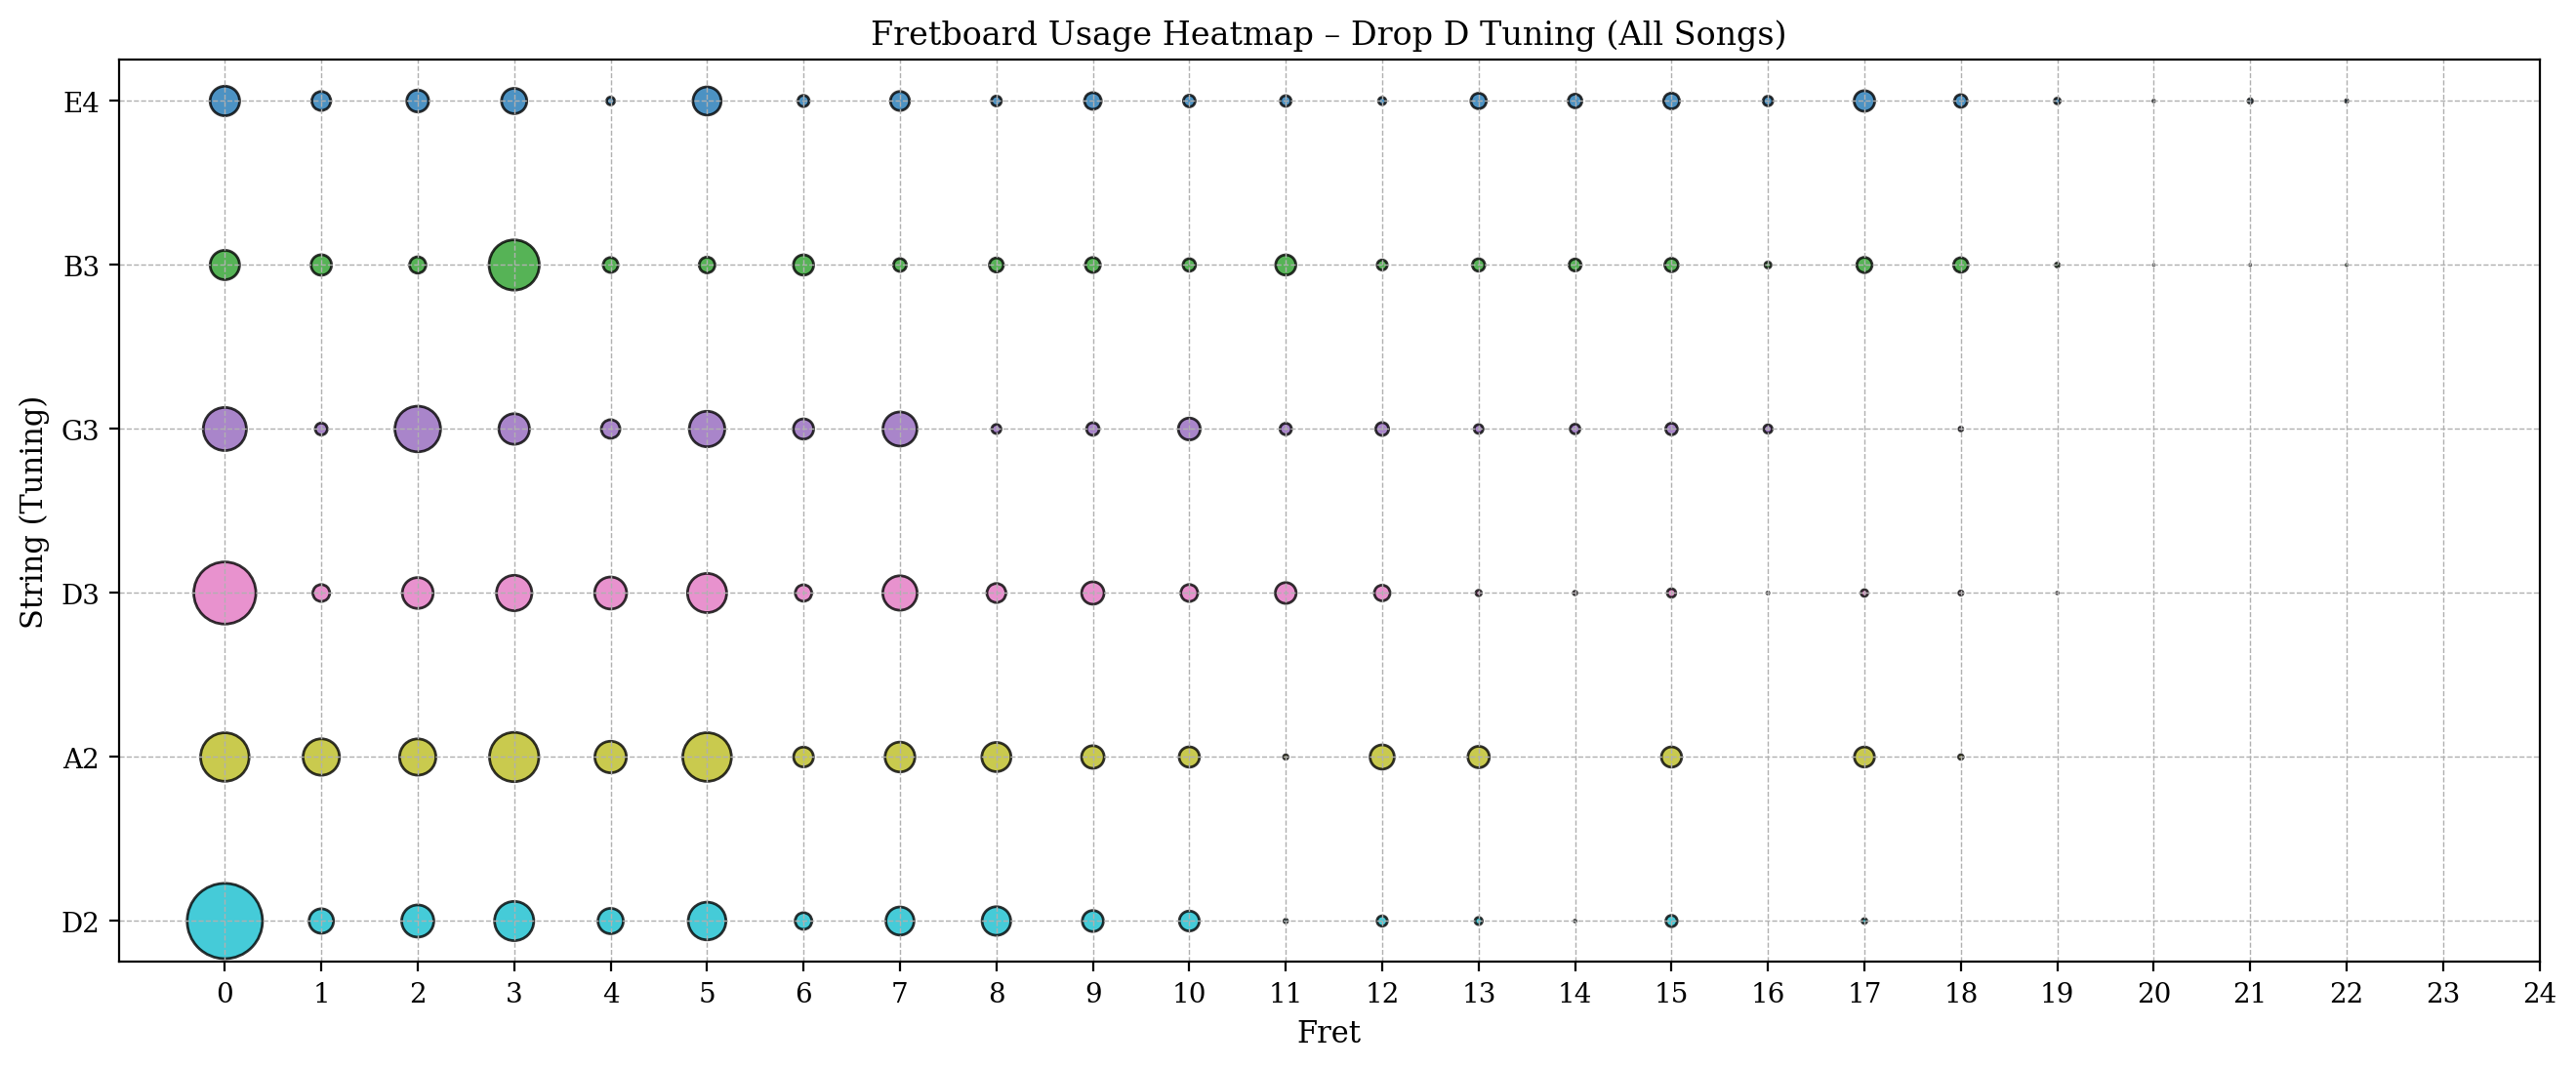

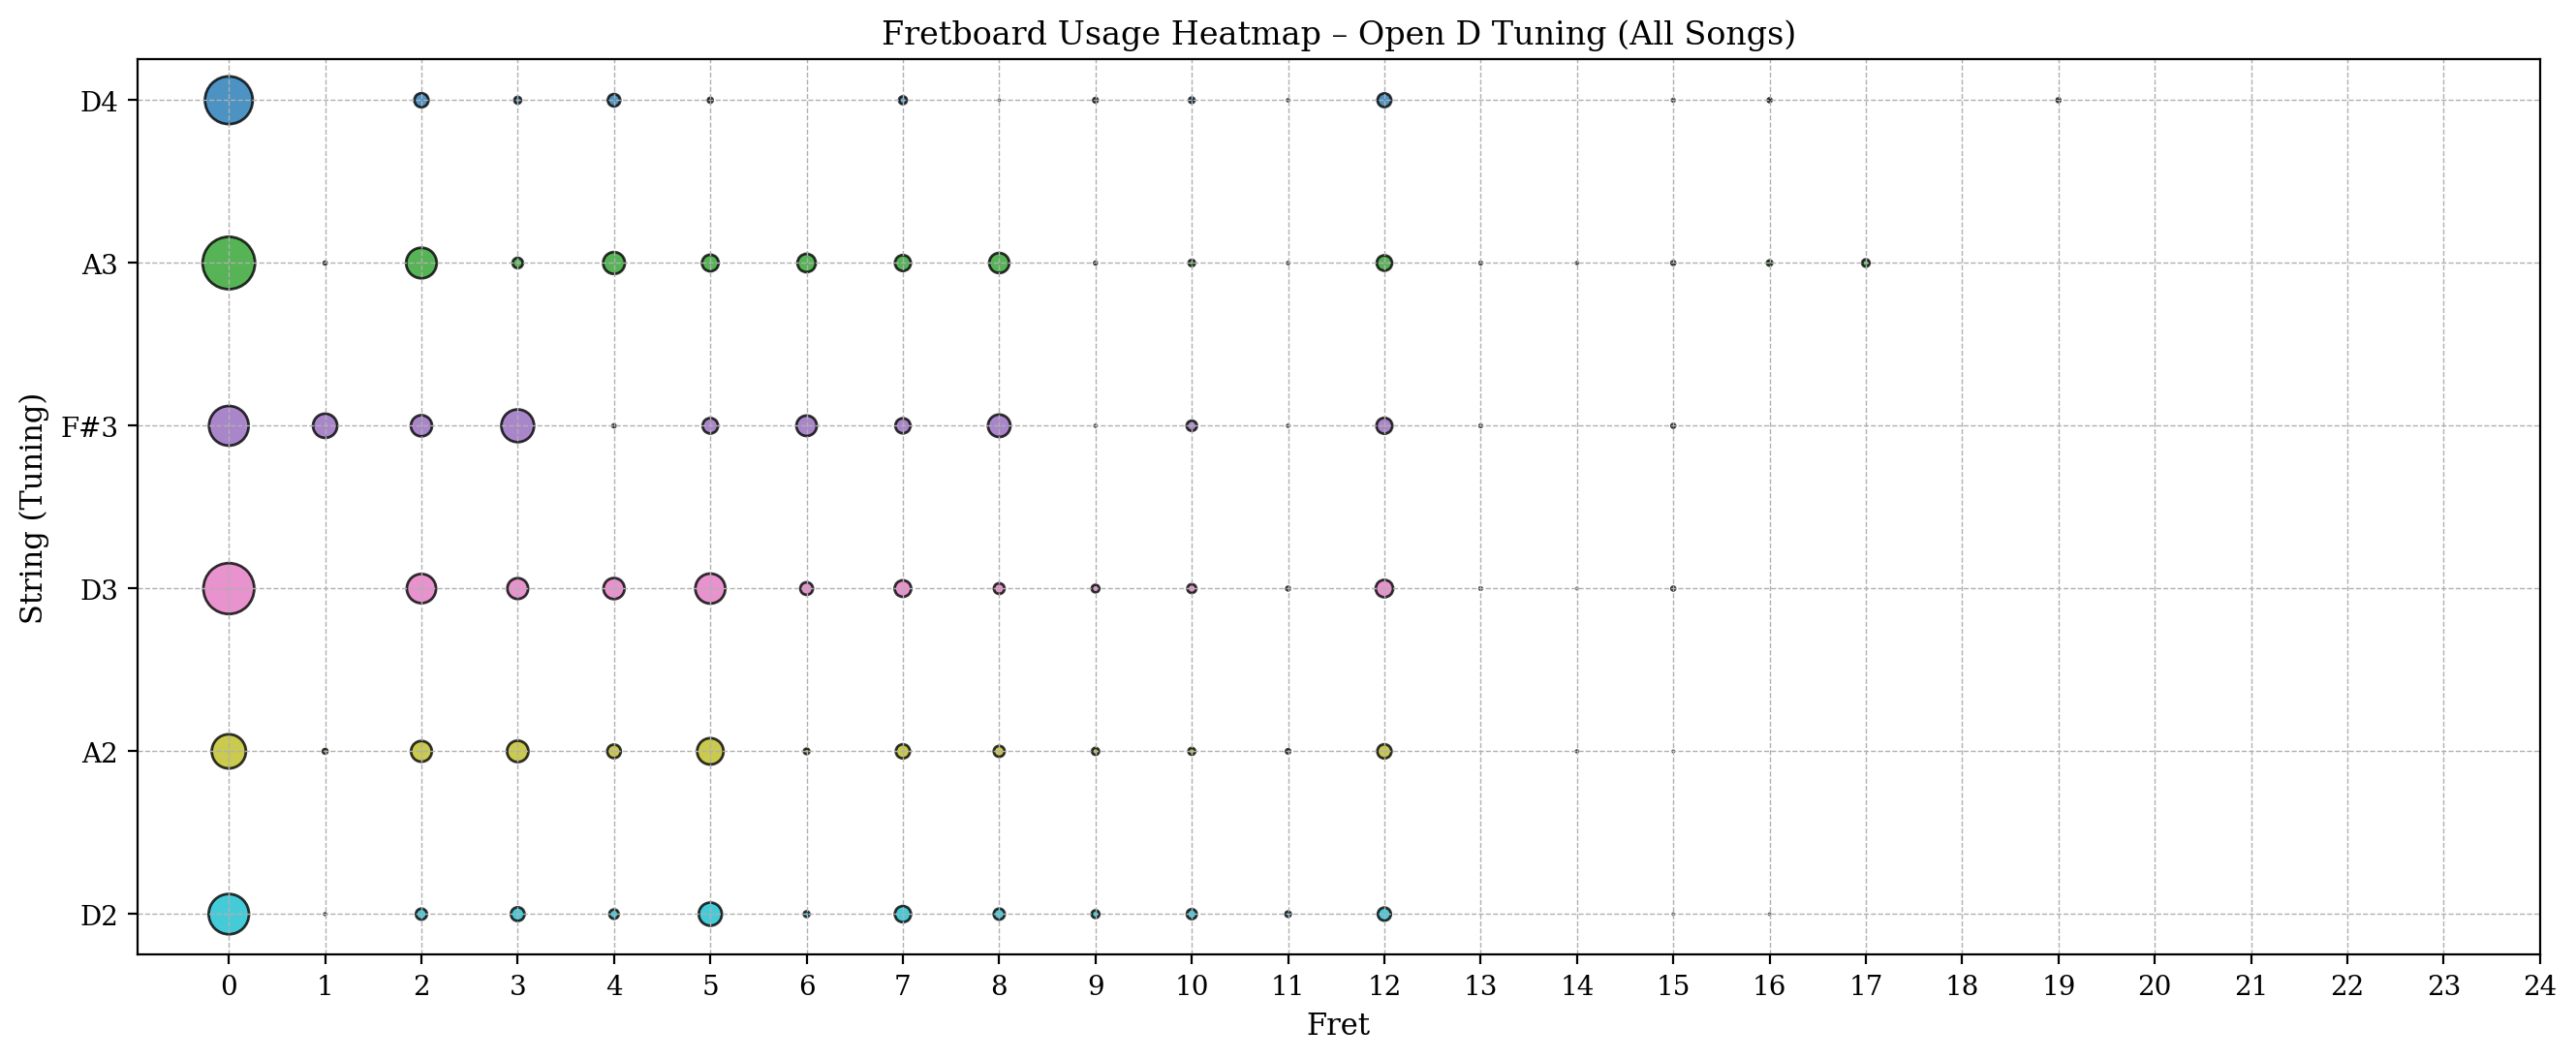

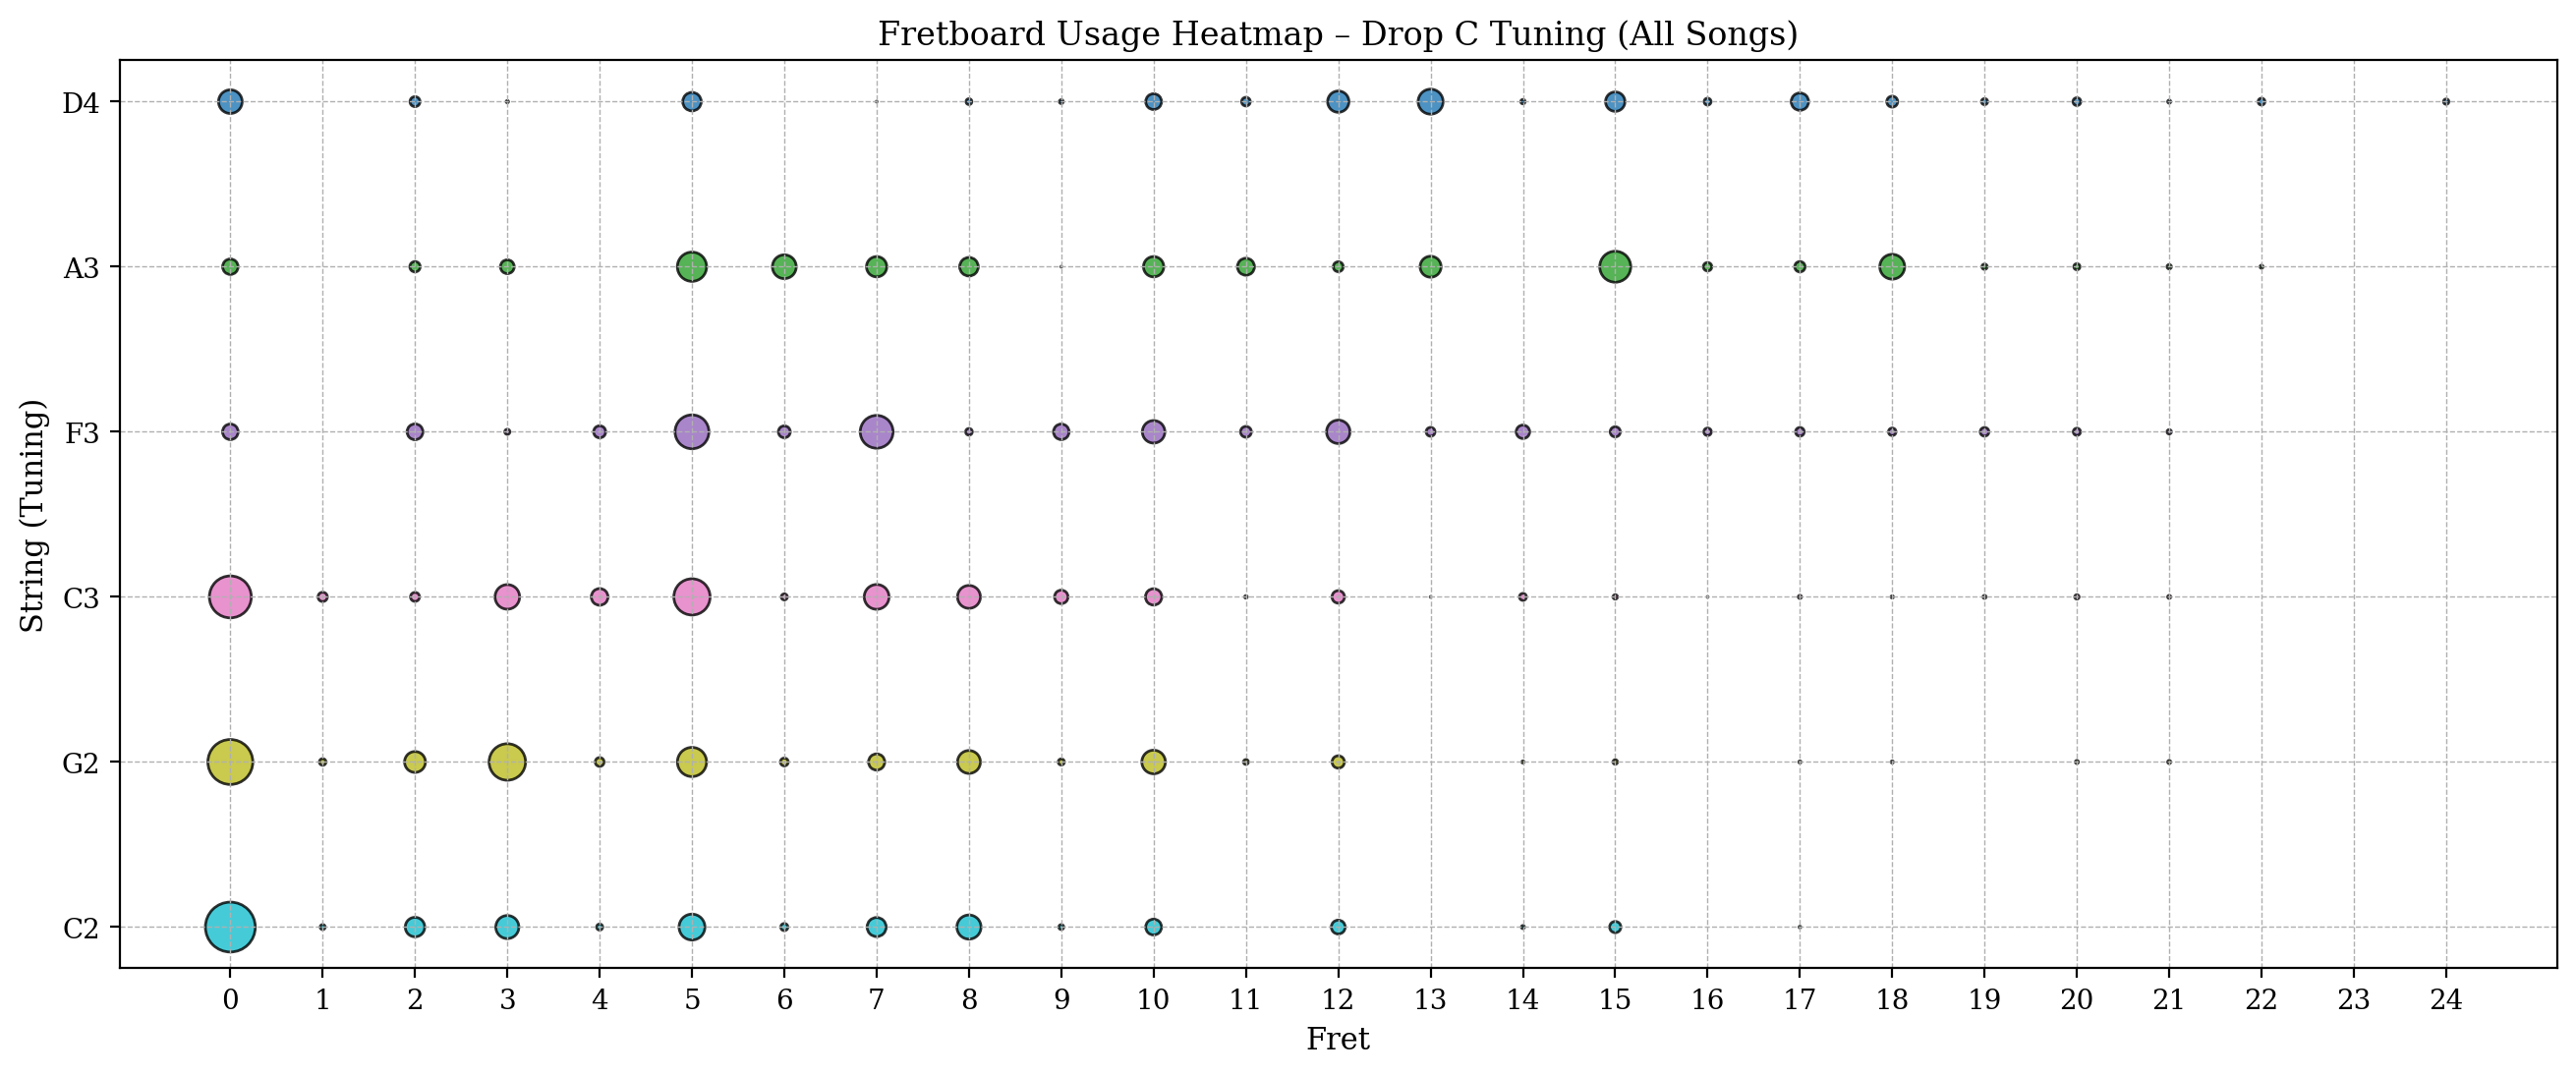

In [ ]:
import matplotlib.pyplot as plt
from music21 import pitch
from collections import defaultdict
import json

from utils import setup_nice_plot, save_plot_with_title

setup_nice_plot()

TUNING_LABELS = {
    "Standard": (64, 59, 55, 50, 45, 40),
    "Drop D": (64, 59, 55, 50, 45, 38),
    "Open D": (62, 57, 54, 50, 45, 38),
    "Drop C": (62, 57, 53, 48, 43, 36),
}

tuning_datasets = {
    "Standard": standard,
    "Drop D": drop_d,
    "Open D": open_d,
    "Drop C": drop_c,
}

for tuning_name, tracks in tuning_datasets.items():
    if not tracks:
        print(f"Skipping {tuning_name} – no data")
        continue

    aggregate_freq = defaultdict(int)

    for track in tracks:
        freq_data = track["string_fret_frequency"]

        total_notes_in_track = sum(
            count for fret_dict in freq_data.values() for count in fret_dict.values()
        )
        if total_notes_in_track == 0:
            continue

        for string_str, fret_dict in freq_data.items():
            string_num = int(string_str)
            for fret_str, count in fret_dict.items():
                fret = int(fret_str)
                proportion = (count / total_notes_in_track) * 100  # normalised per track
                aggregate_freq[(string_num, fret)] += proportion
    # Plot data prep
    x, y, sizes, colors = [], [], [], []

    for (string_num, fret), count in aggregate_freq.items():
        x.append(fret)
        y.append(6 - string_num)
        sizes.append(count * 2)
        colors.append(string_num)

    # Get most common tuning in the group for labeling
    common_tuning = TUNING_LABELS.get(tuning_name, [64, 59, 55, 50, 45, 40])
    string_labels = []
    for midi_val in common_tuning:
        p = pitch.Pitch()
        p.midi = midi_val
        string_labels.append(p.nameWithOctave)

    # Plot
    plt.figure(figsize=(16, 6))
    plt.scatter(x, y, s=sizes, c=colors, cmap='tab10', alpha=0.8, edgecolors='k')

    plt.xticks(range(0, 25))
    plt.yticks(range(6), string_labels[::-1])
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.xlabel("Fret")
    plt.ylabel("String (Tuning)")
    plt.title(f"Fretboard Usage Heatmap – {tuning_name} Tuning (All Songs)")

    save_path = f"../figures/fretboard_usage_heatmap_all_songs{tuning_name}.png"
    plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()

In [ ]:
from collections import defaultdict

total_usage = defaultdict(int)

for track in standard:
    for i in range(1, 7):
        string_data = track["string_fret_frequency"].get(str(i), {})
        total_usage[i] += sum(string_data.values())

# Convert to regular dict for pretty printing
dict(total_usage)

{1: 11215, 2: 17388, 3: 19868, 4: 17791, 5: 16700, 6: 7974}

In [ ]:
standard

[{'title': 'Even Flow',
  'artist': 'Pearl Jam',
  'track_name': 'Guitar 2',
  'tuning': [64, 59, 55, 50, 45, 40],
  'tuning_label': 'Standard',
  'string_fret_frequency': {'1': {'10': 11, '15': 2, '0': 4, '13': 1, '12': 1},
   '2': {'0': 146,
    '5': 48,
    '7': 66,
    '8': 4,
    '3': 4,
    '10': 26,
    '13': 10,
    '15': 24},
   '3': {'0': 252,
    '5': 87,
    '7': 128,
    '3': 17,
    '12': 38,
    '10': 45,
    '19': 1,
    '6': 2},
   '4': {'7': 136,
    '0': 153,
    '5': 54,
    '6': 11,
    '3': 6,
    '12': 60,
    '10': 28,
    '11': 5},
   '5': {'8': 13, '5': 33, '0': 45, '12': 7, '11': 4, '10': 4},
   '6': {'10': 6, '13': 2, '0': 9, '8': 10, '9': 2, '12': 2}}},
 {'title': 'Even Flow',
  'artist': 'Pearl Jam',
  'track_name': 'Guitar 3',
  'tuning': [64, 59, 55, 50, 45, 40],
  'tuning_label': 'Standard',
  'string_fret_frequency': {'1': {'15': 3, '0': 3, '13': 4, '10': 1},
   '2': {'0': 2, '15': 1, '10': 3, '13': 2},
   '3': {'0': 1, '10': 2, '12': 1},
   '4': {},
 

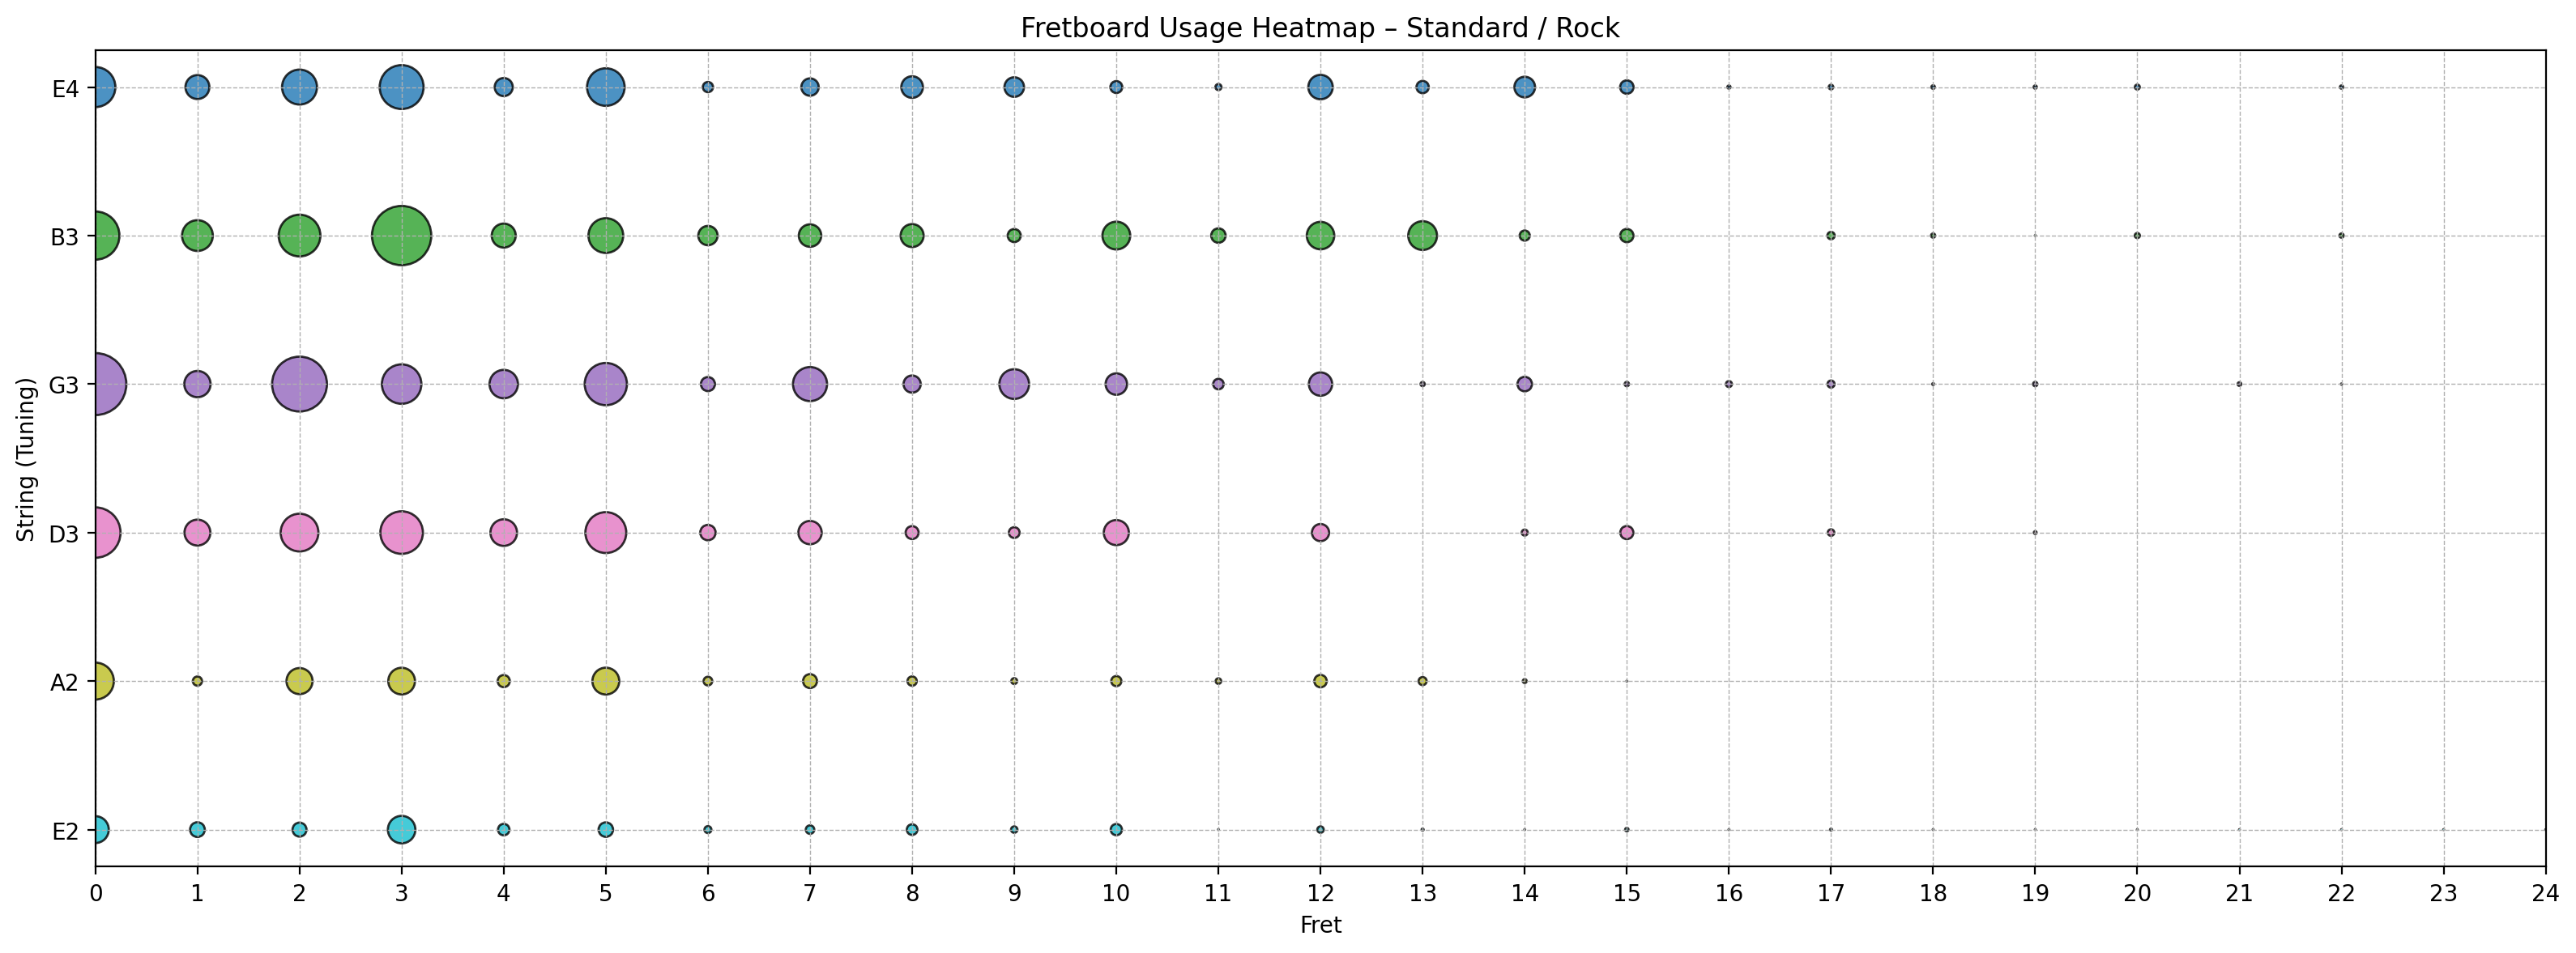

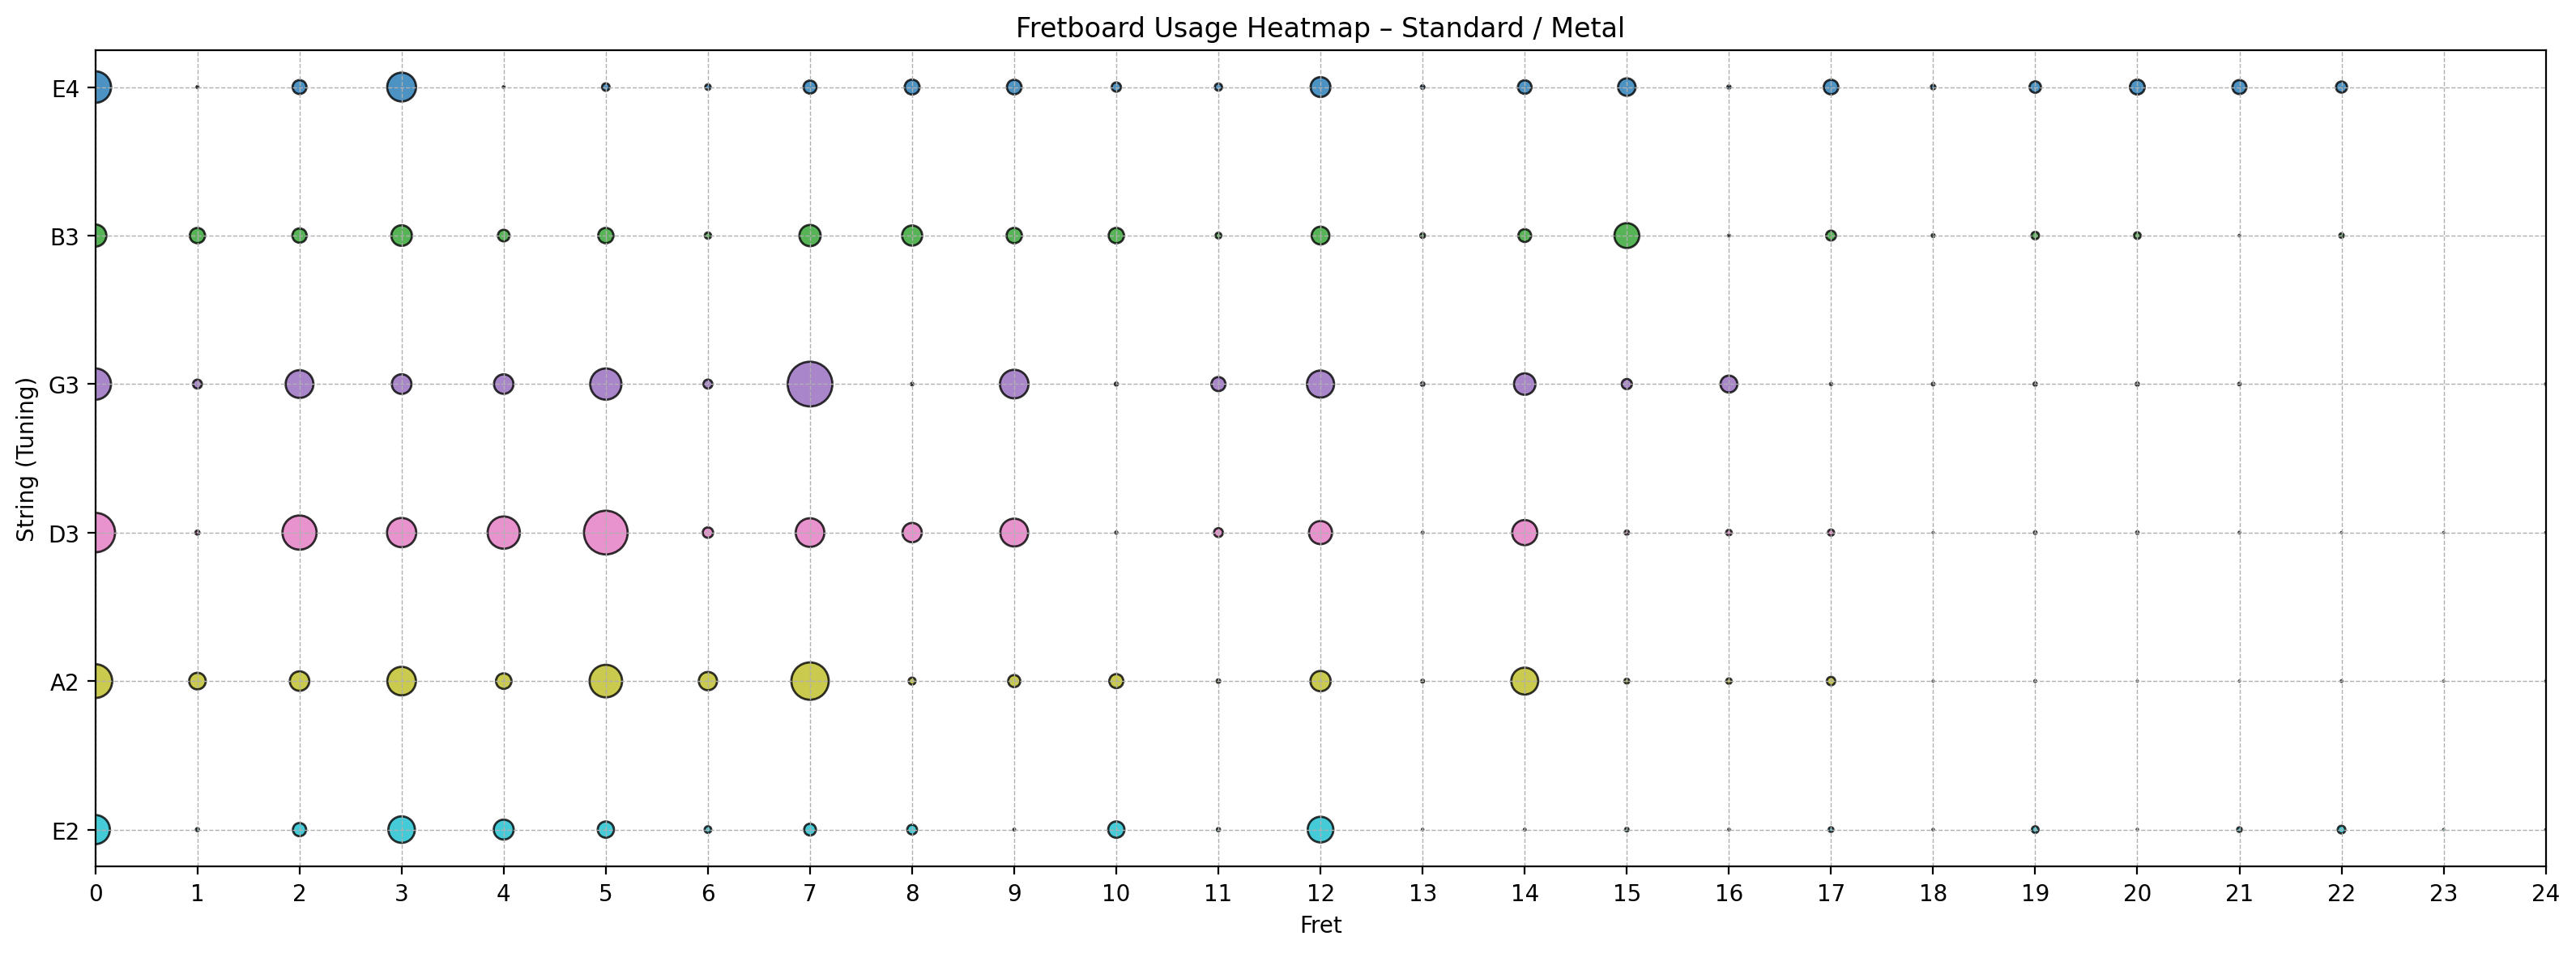

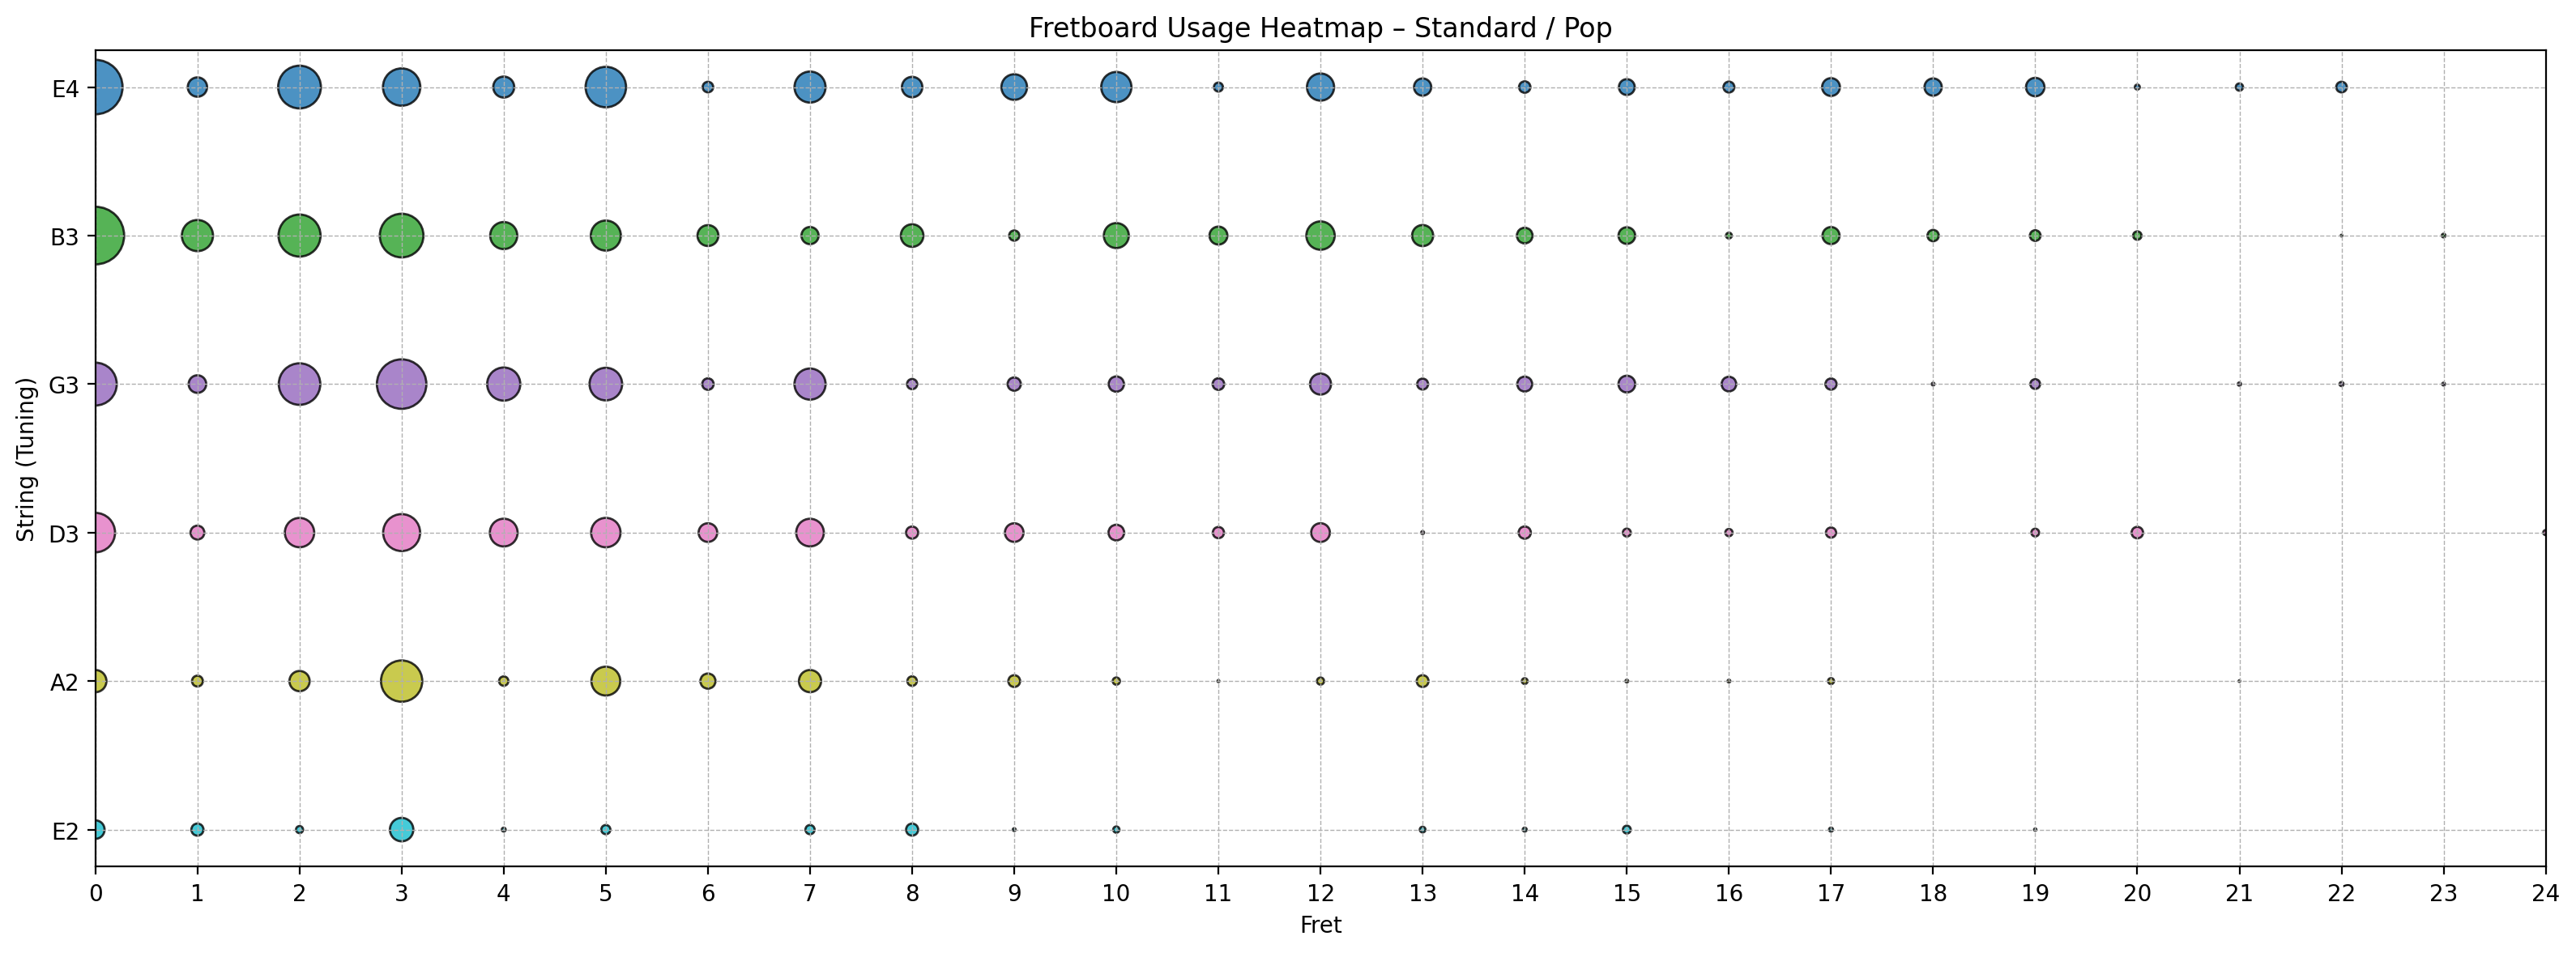

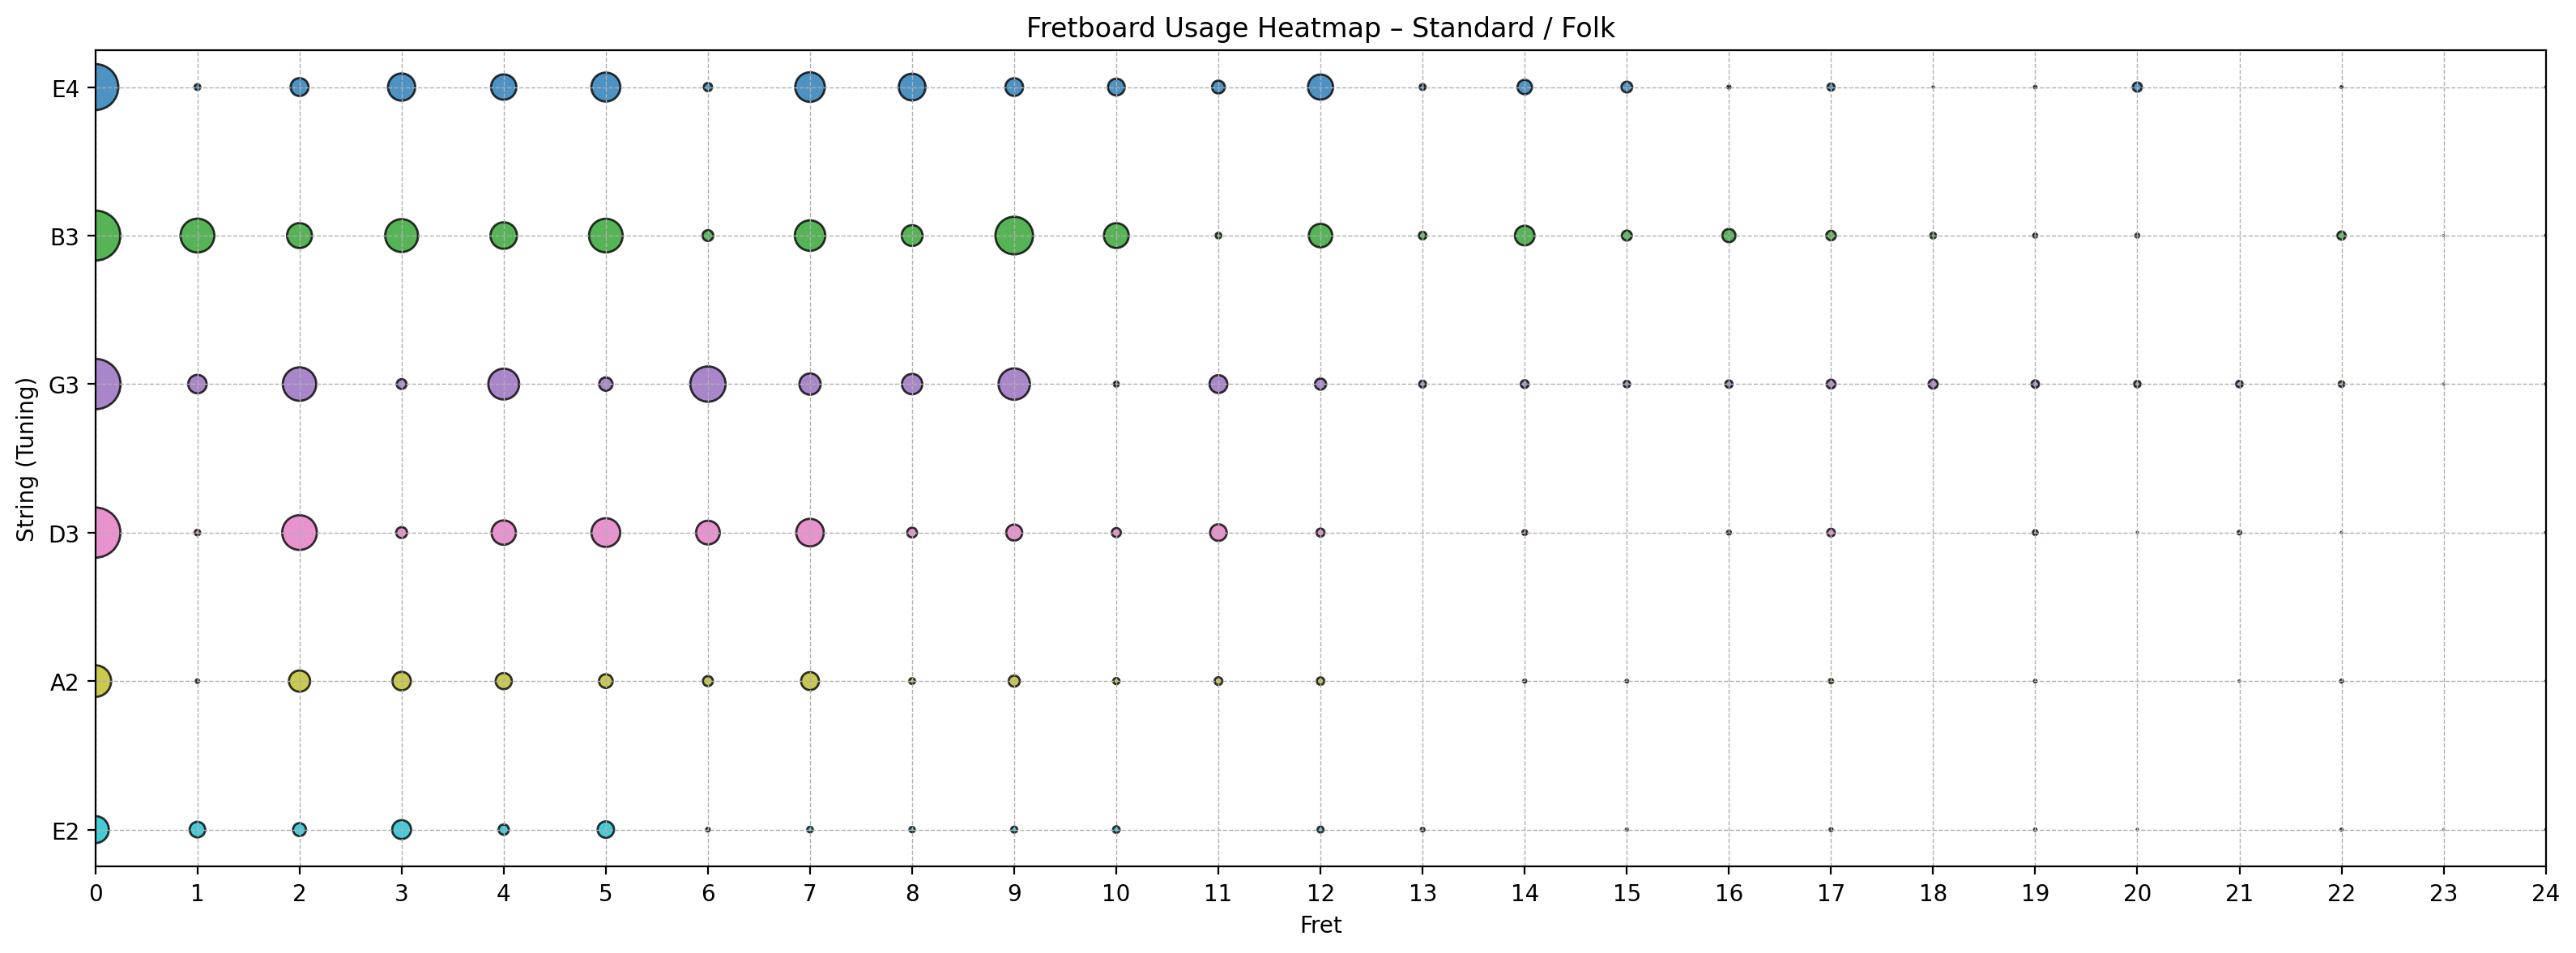

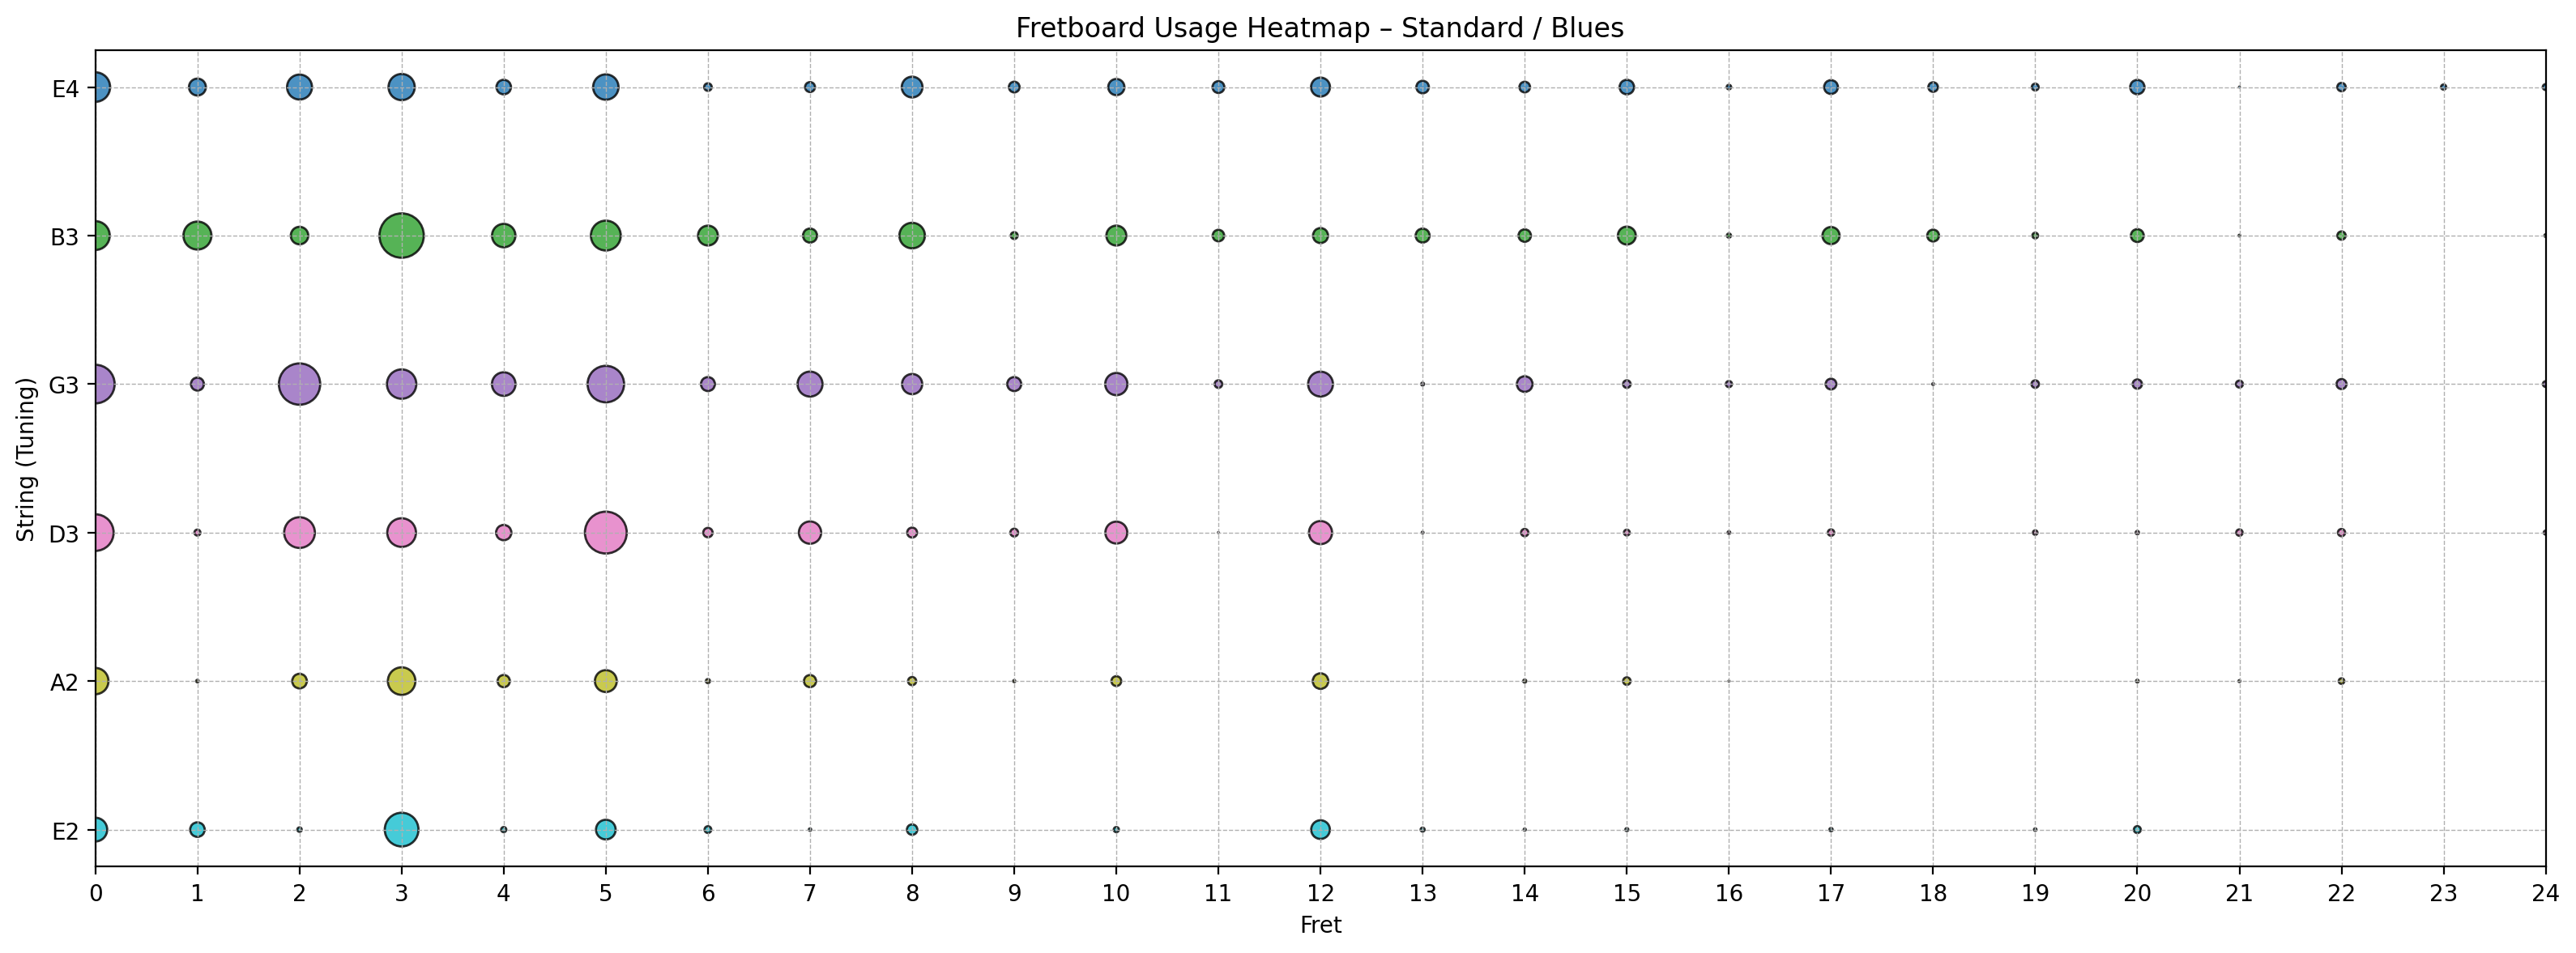

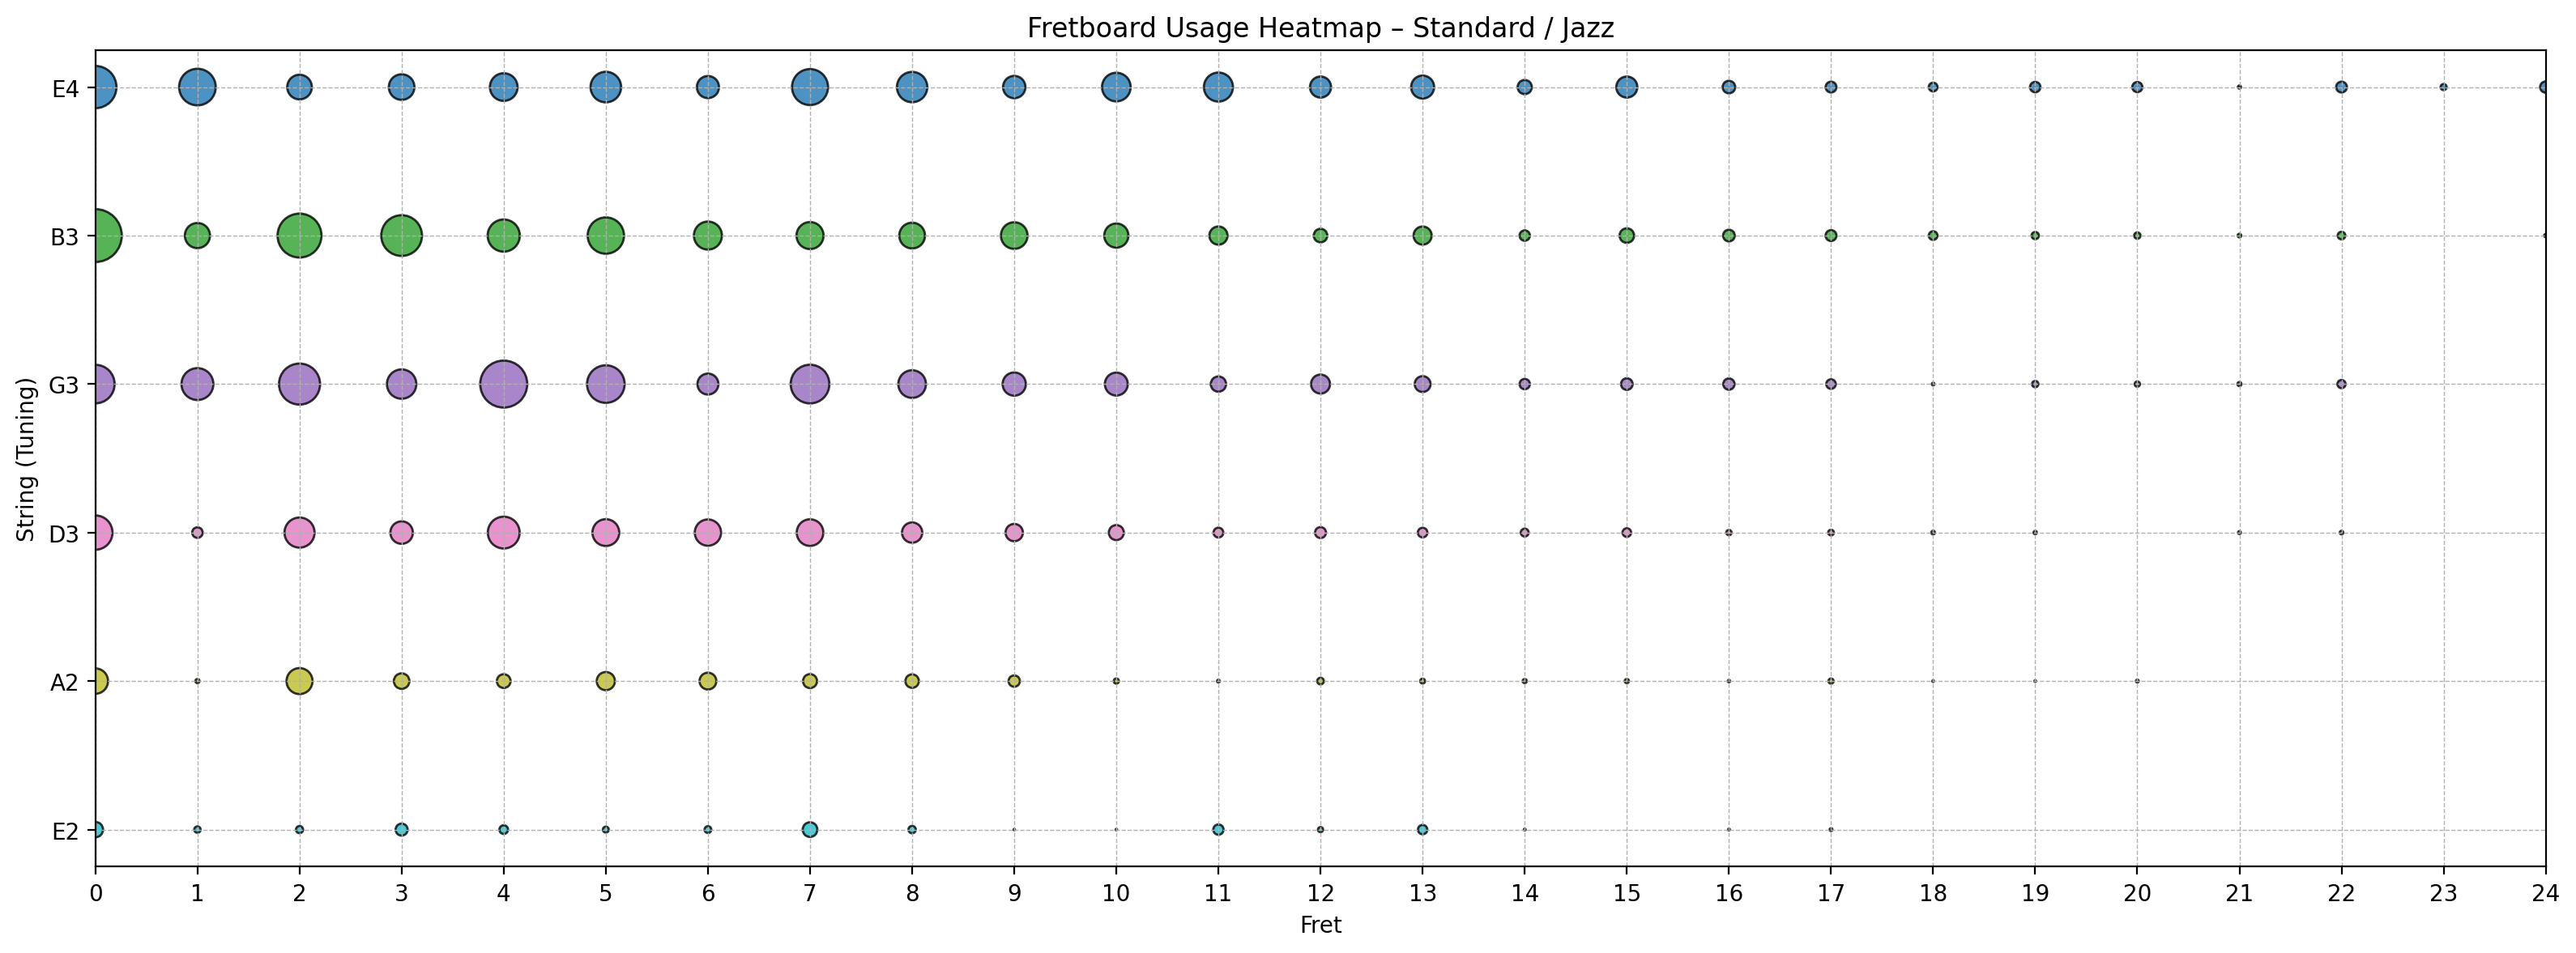

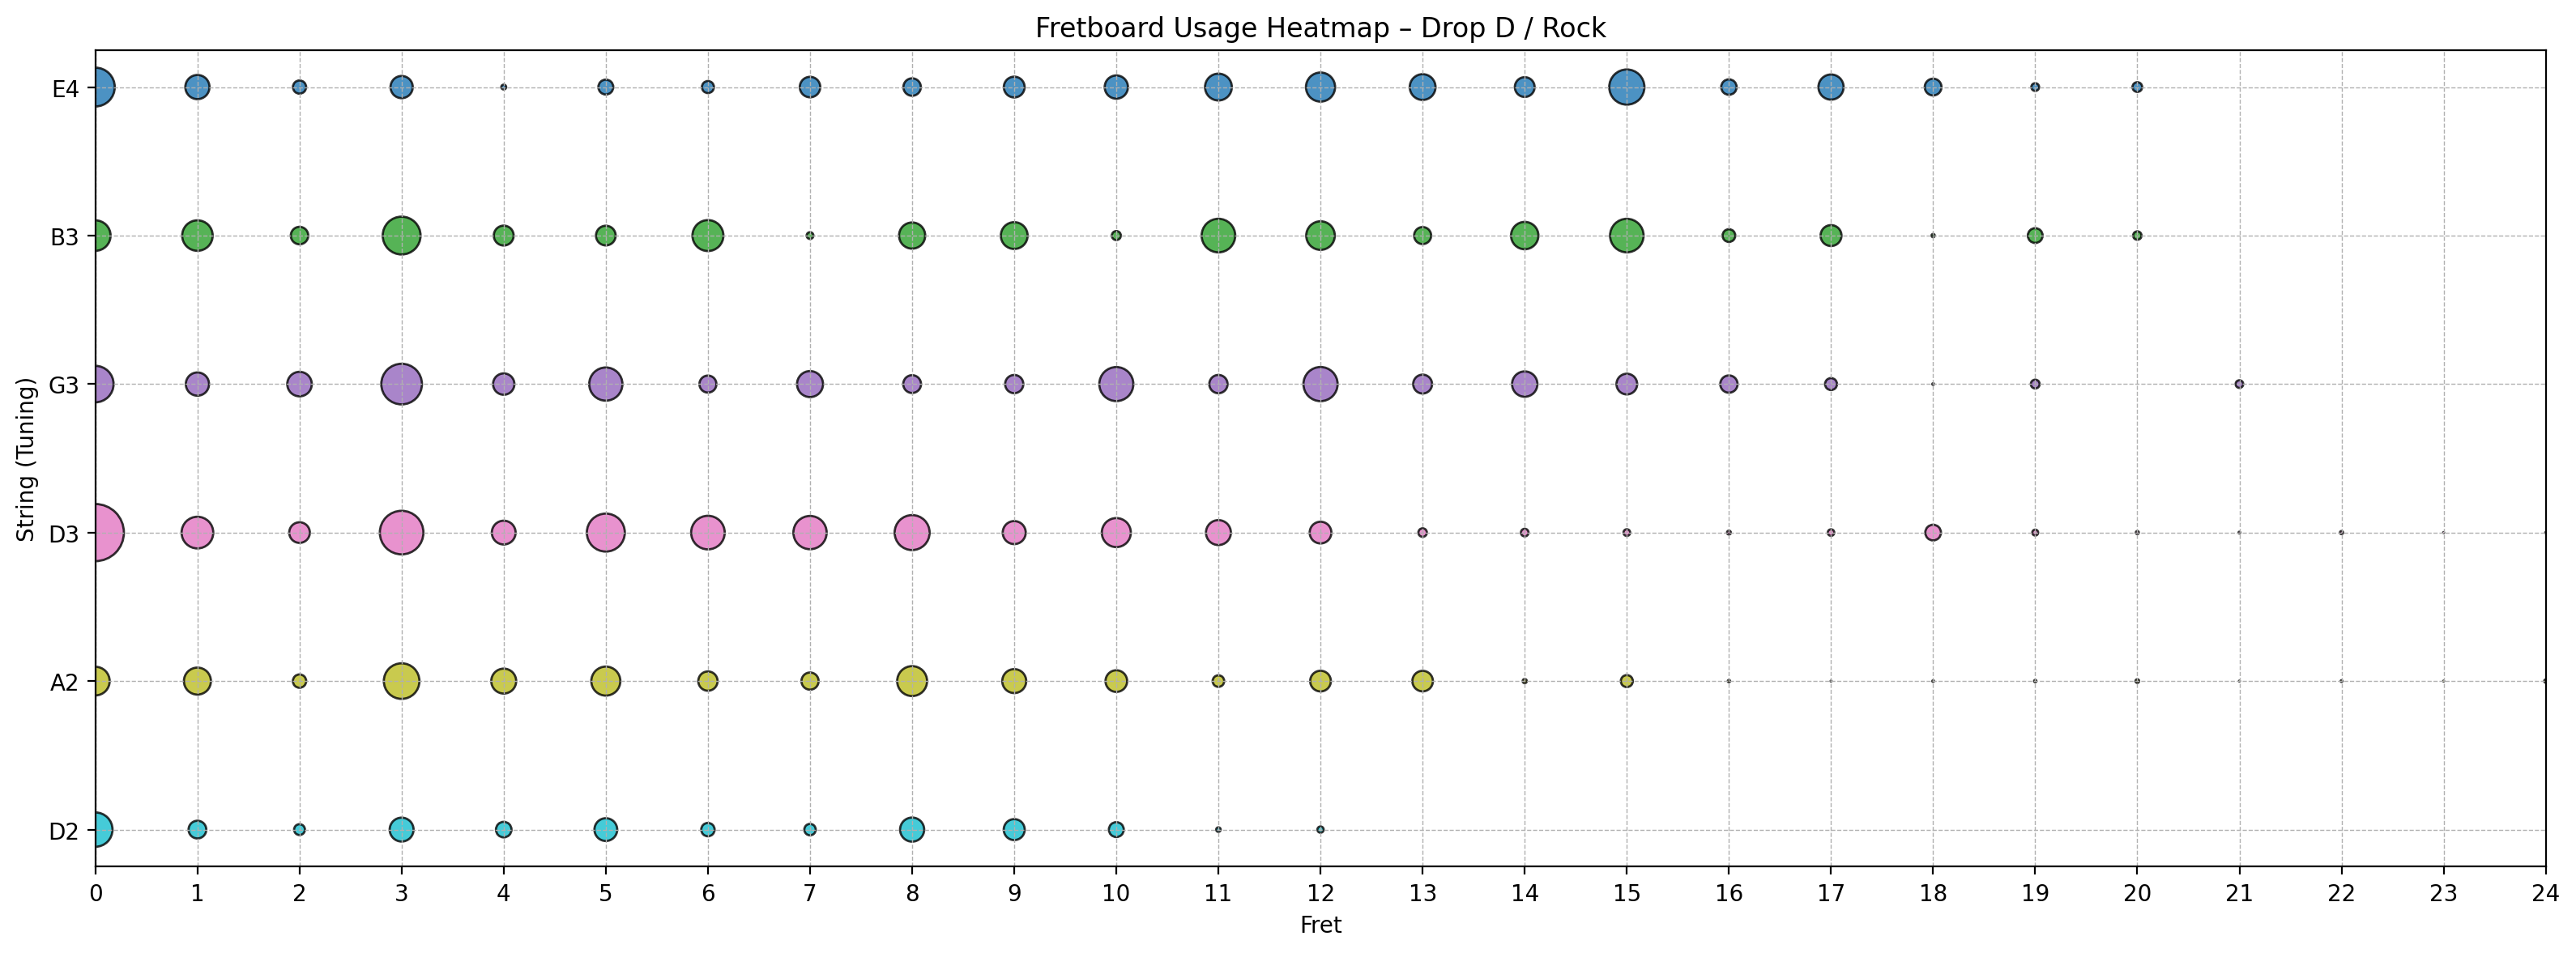

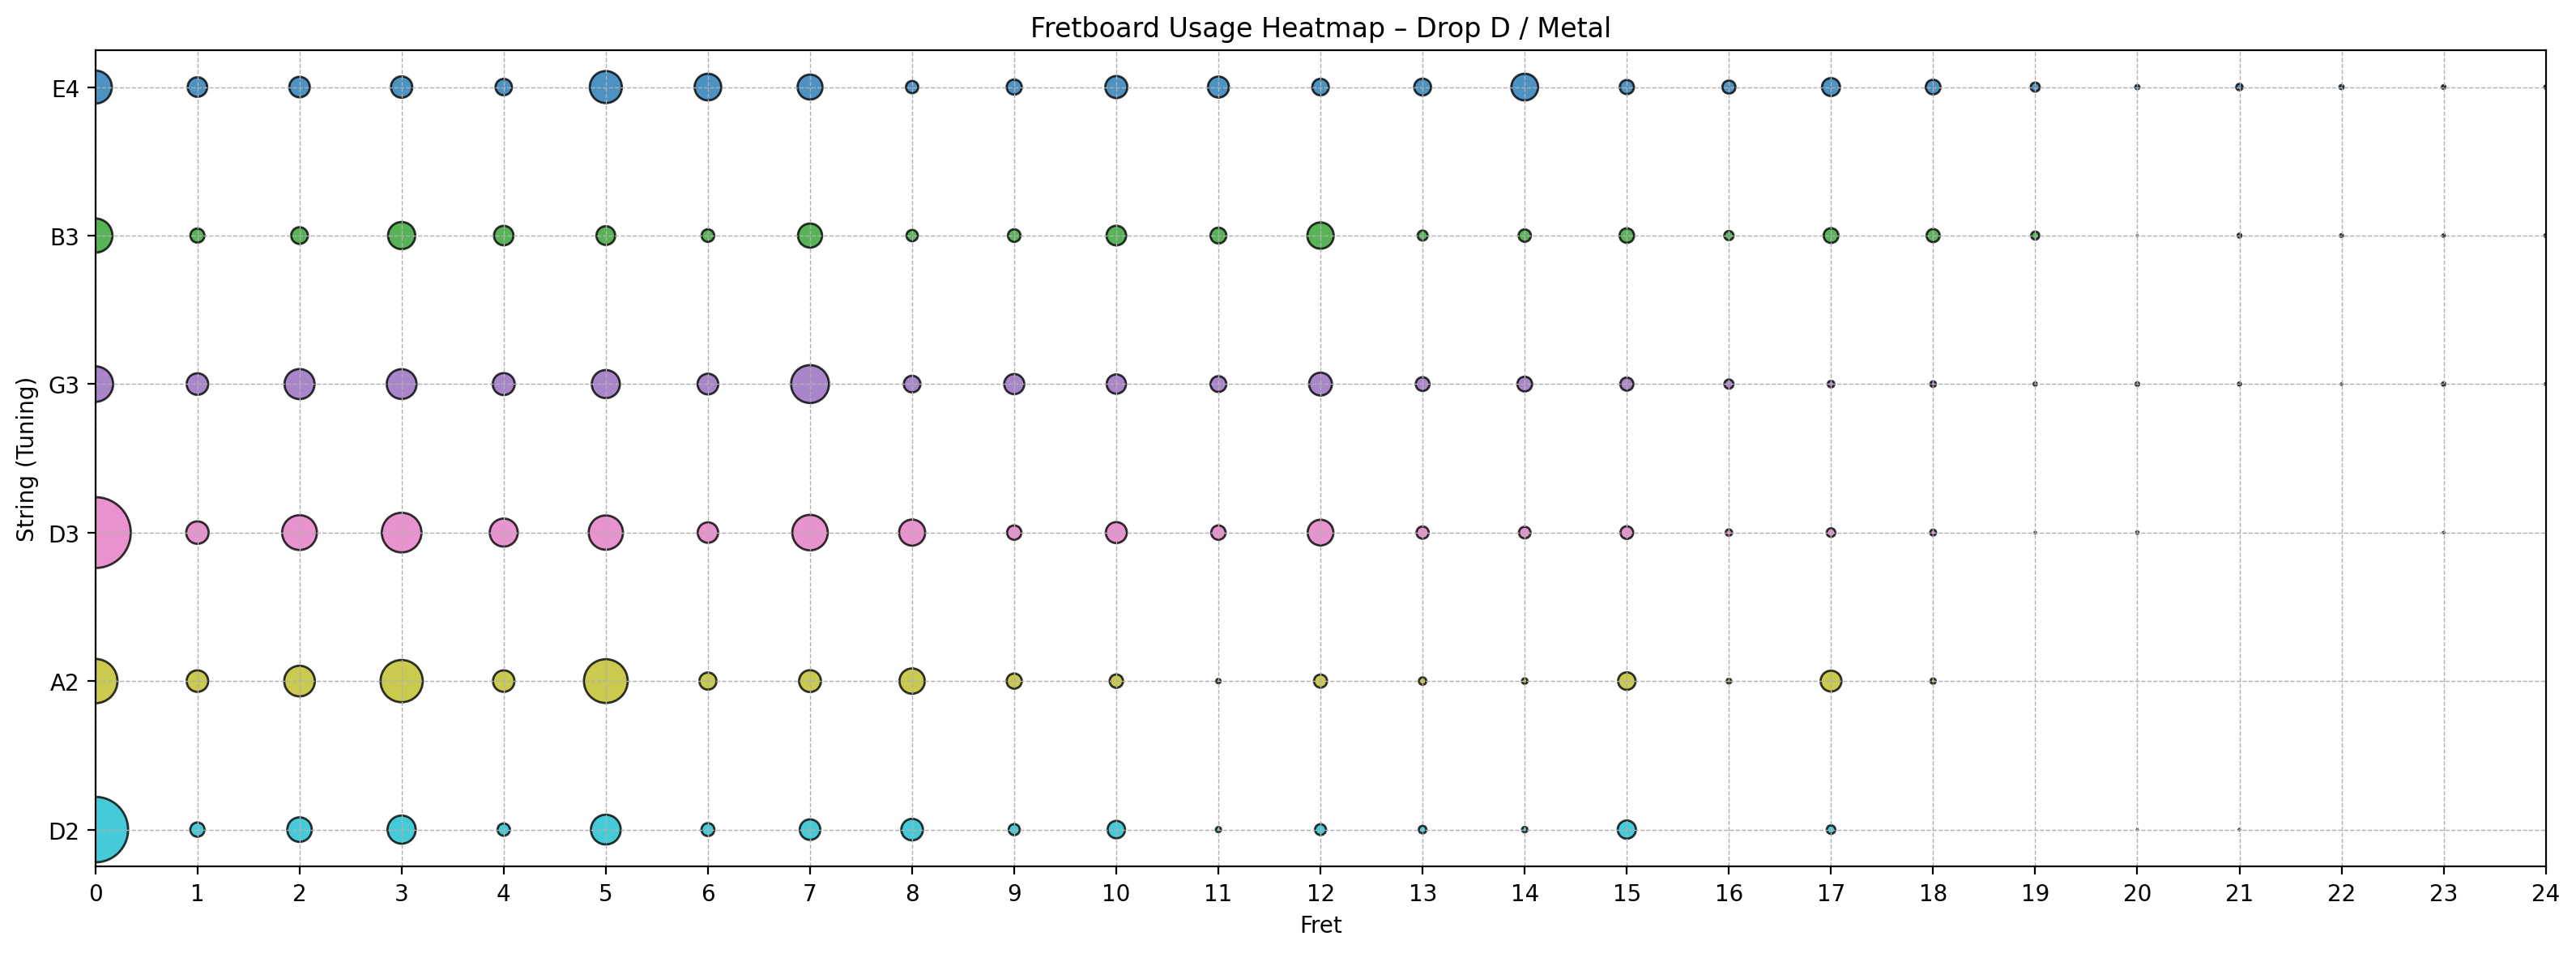

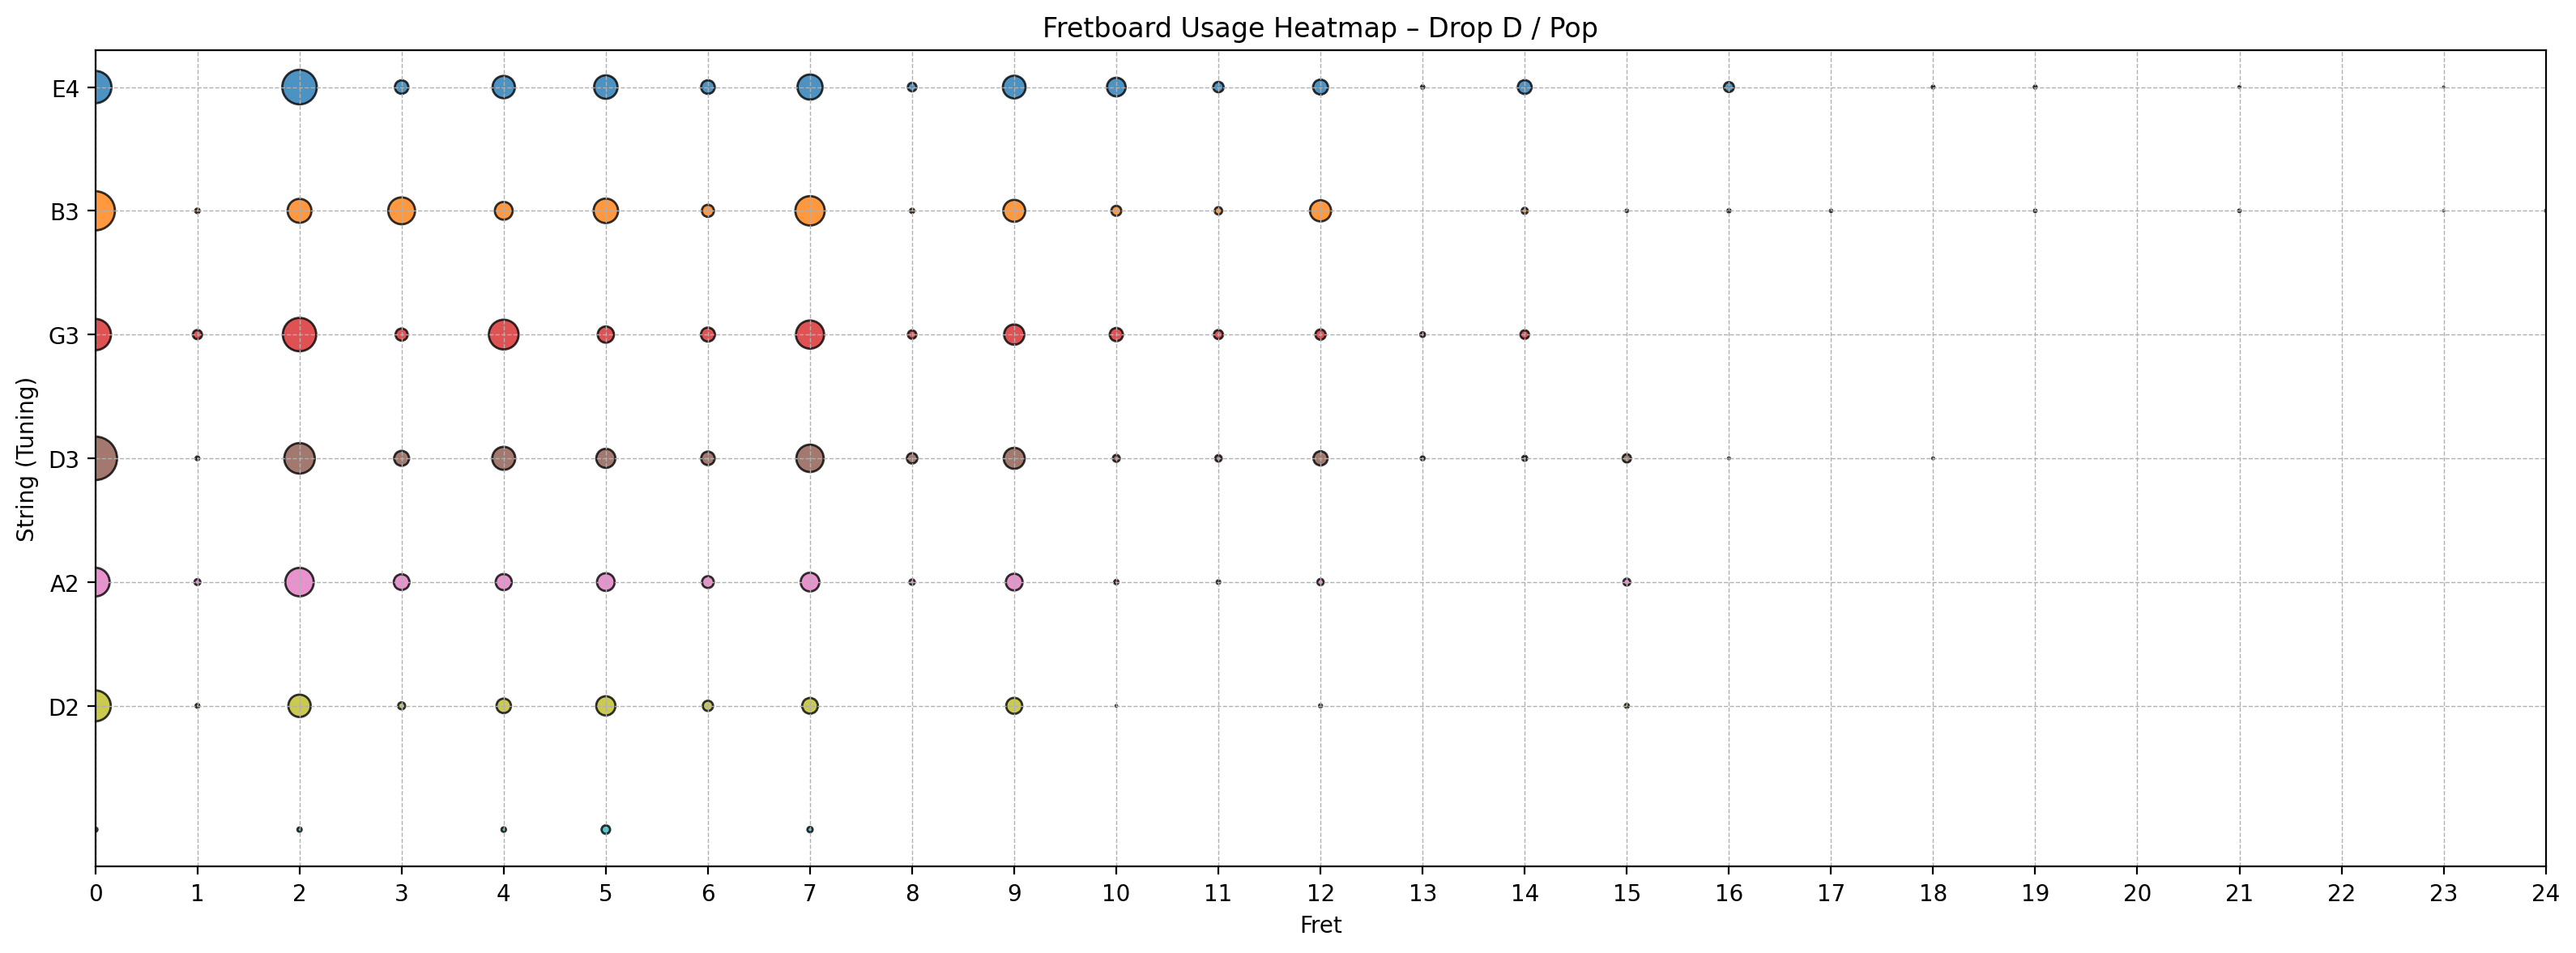

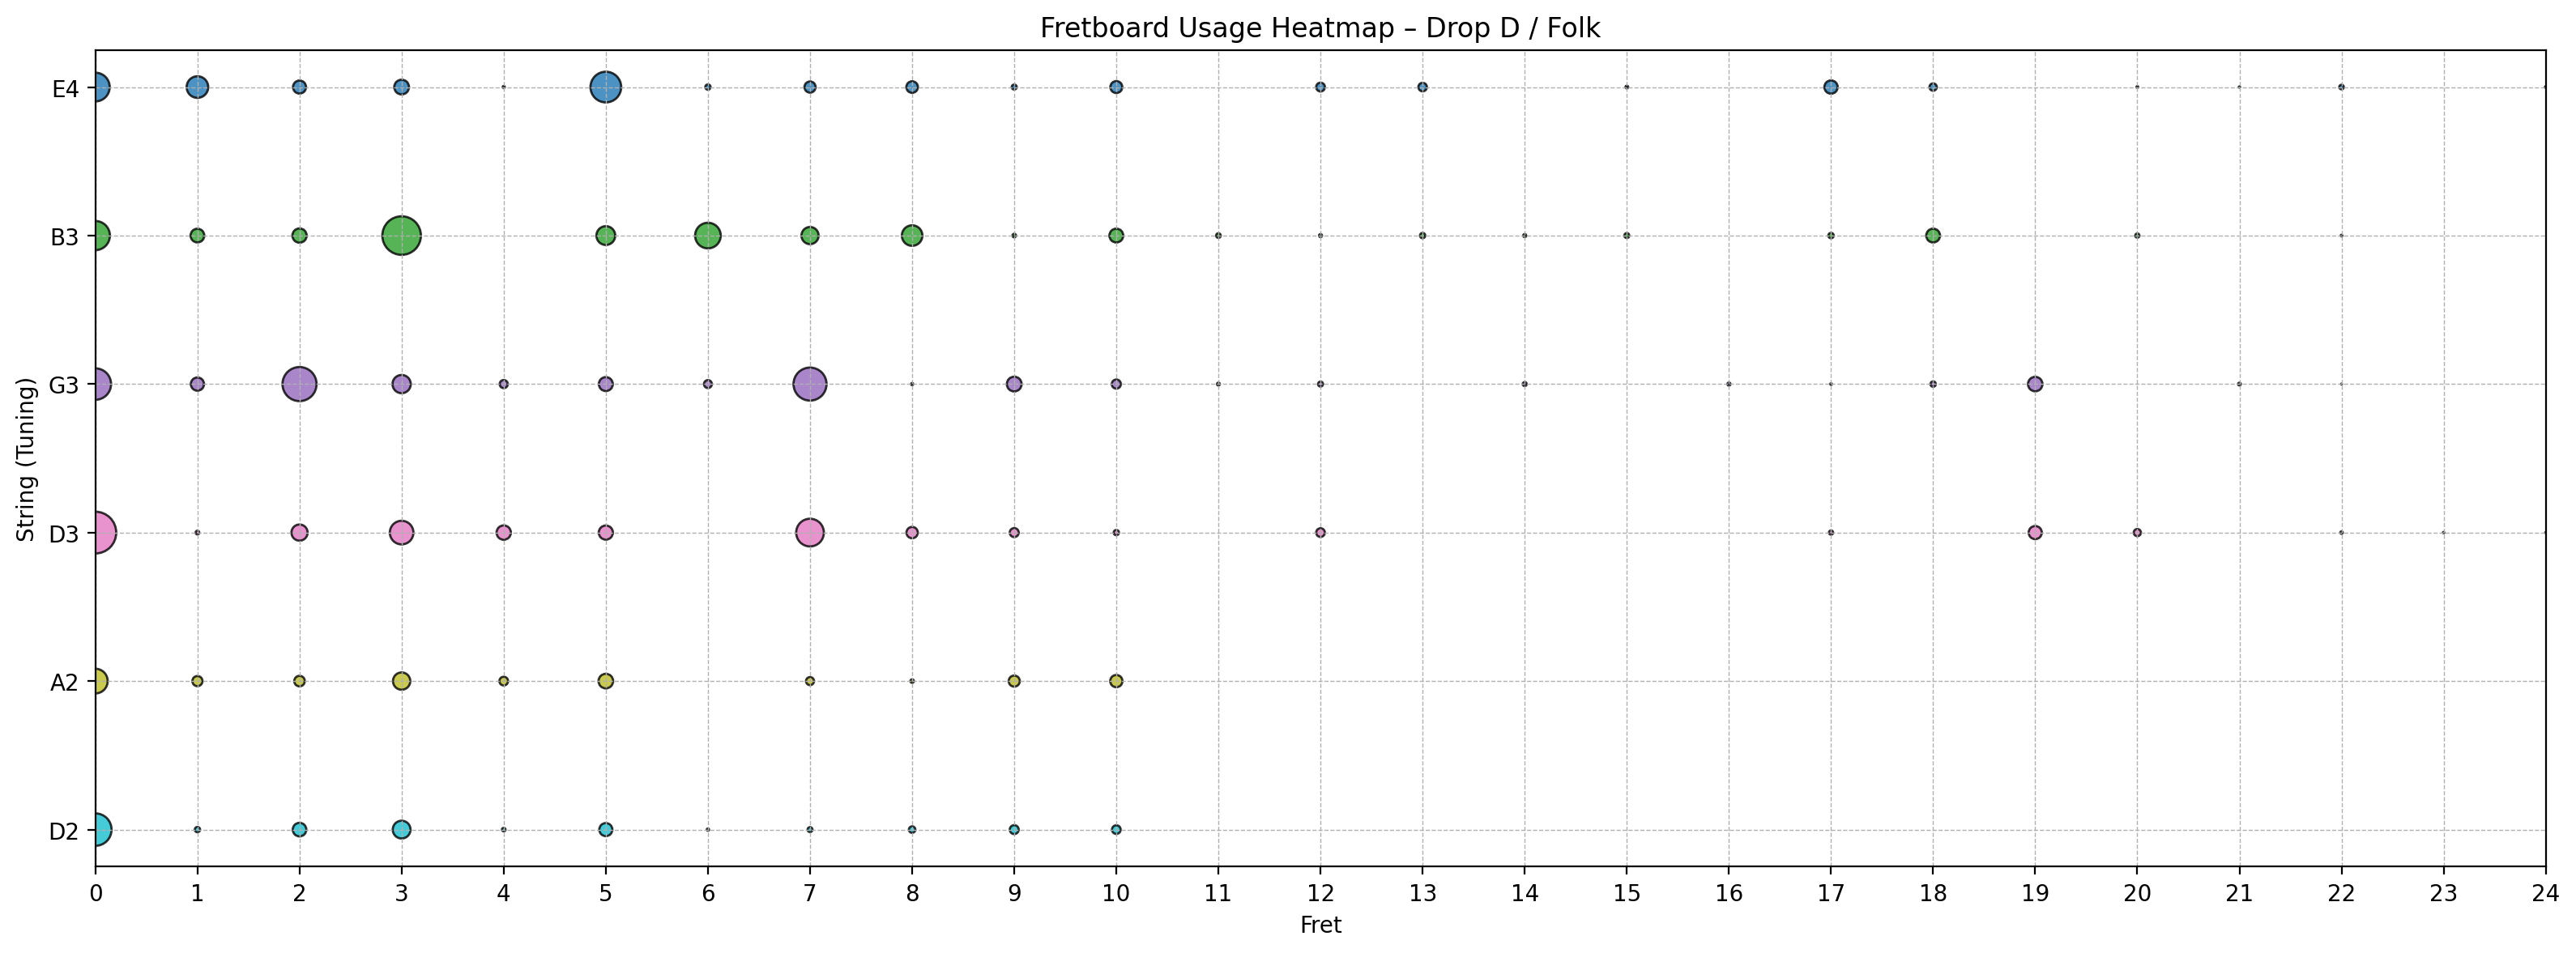

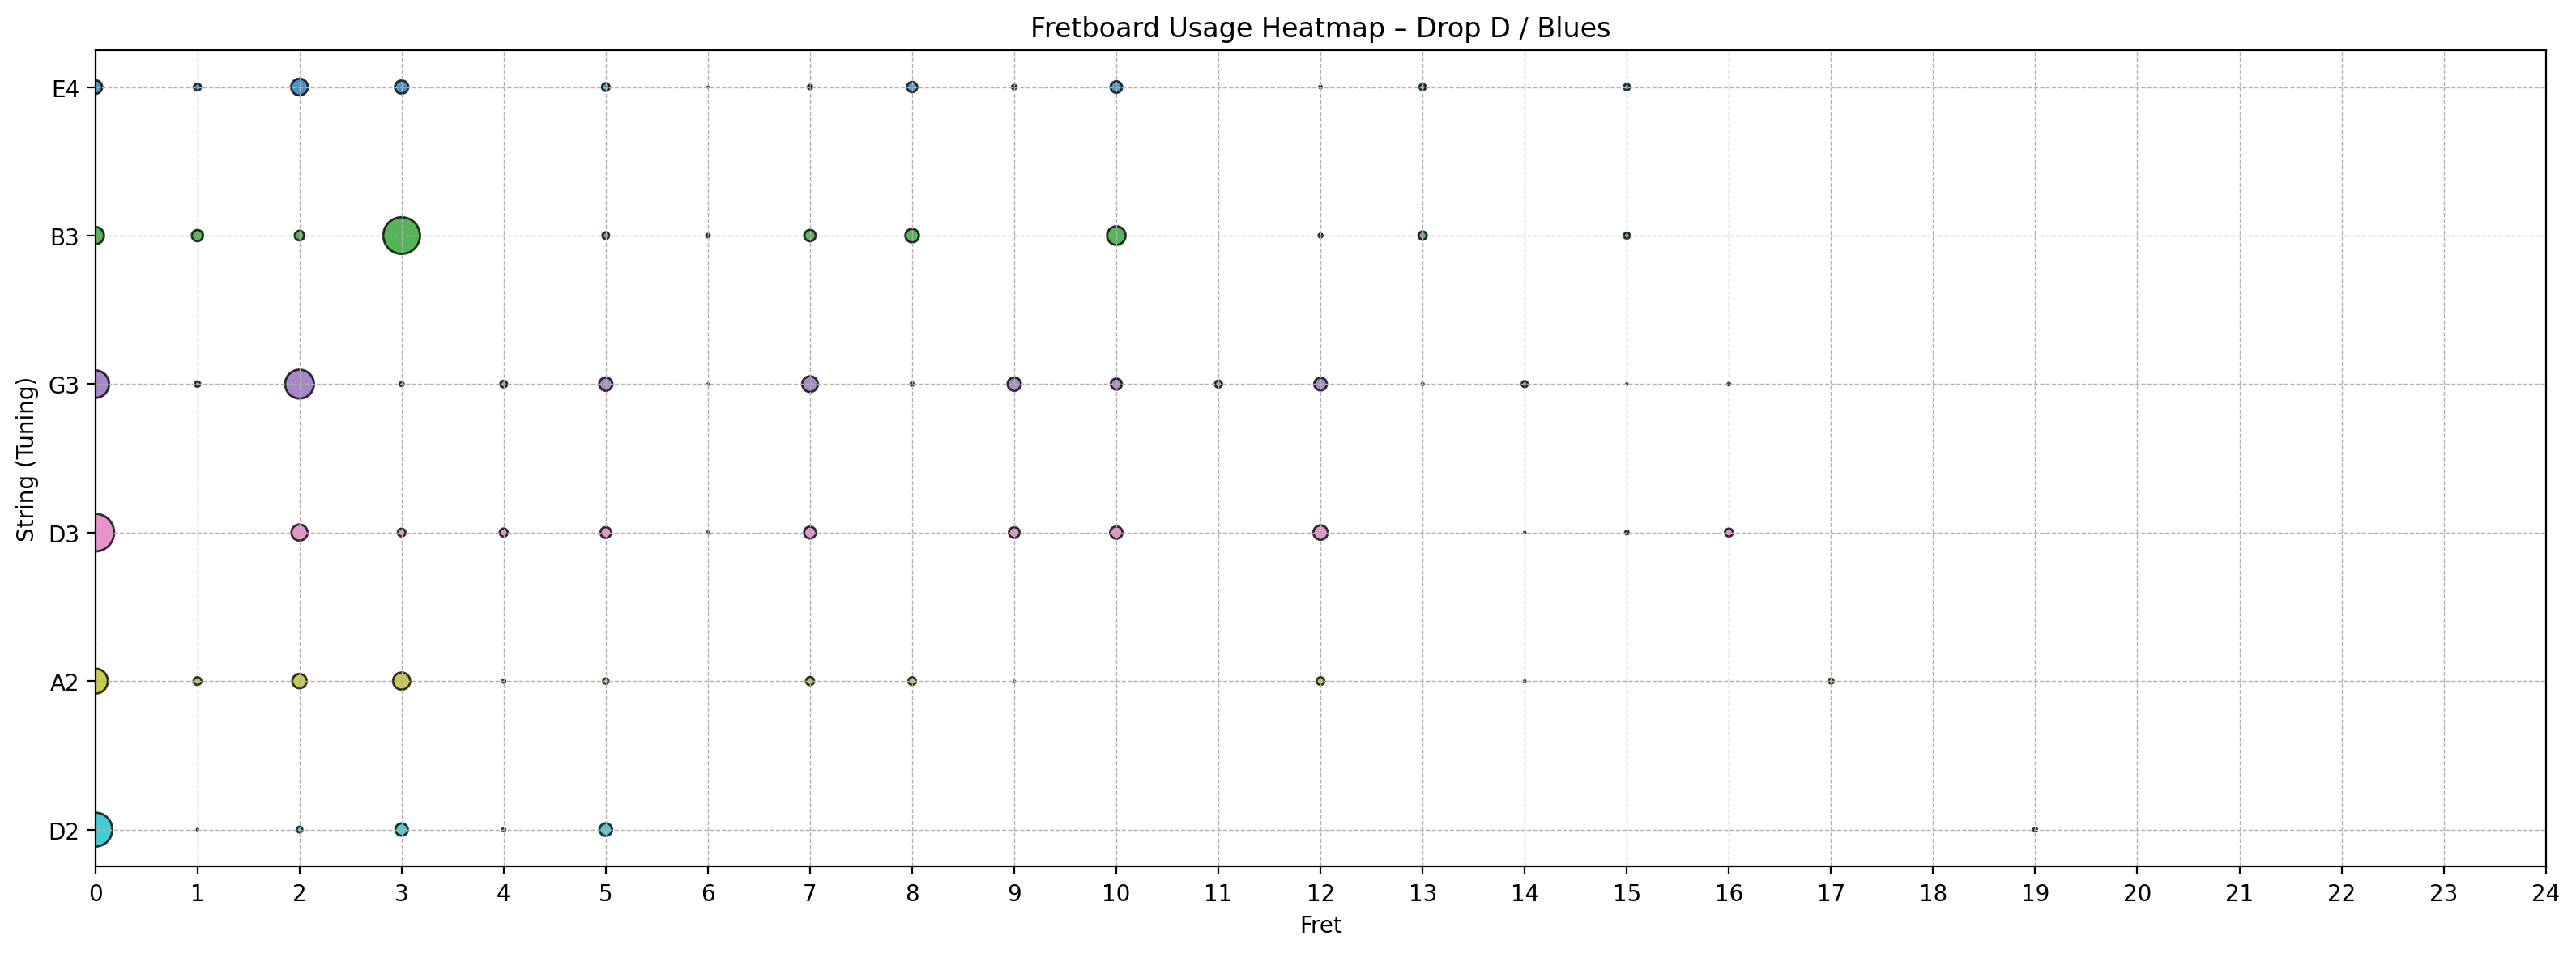

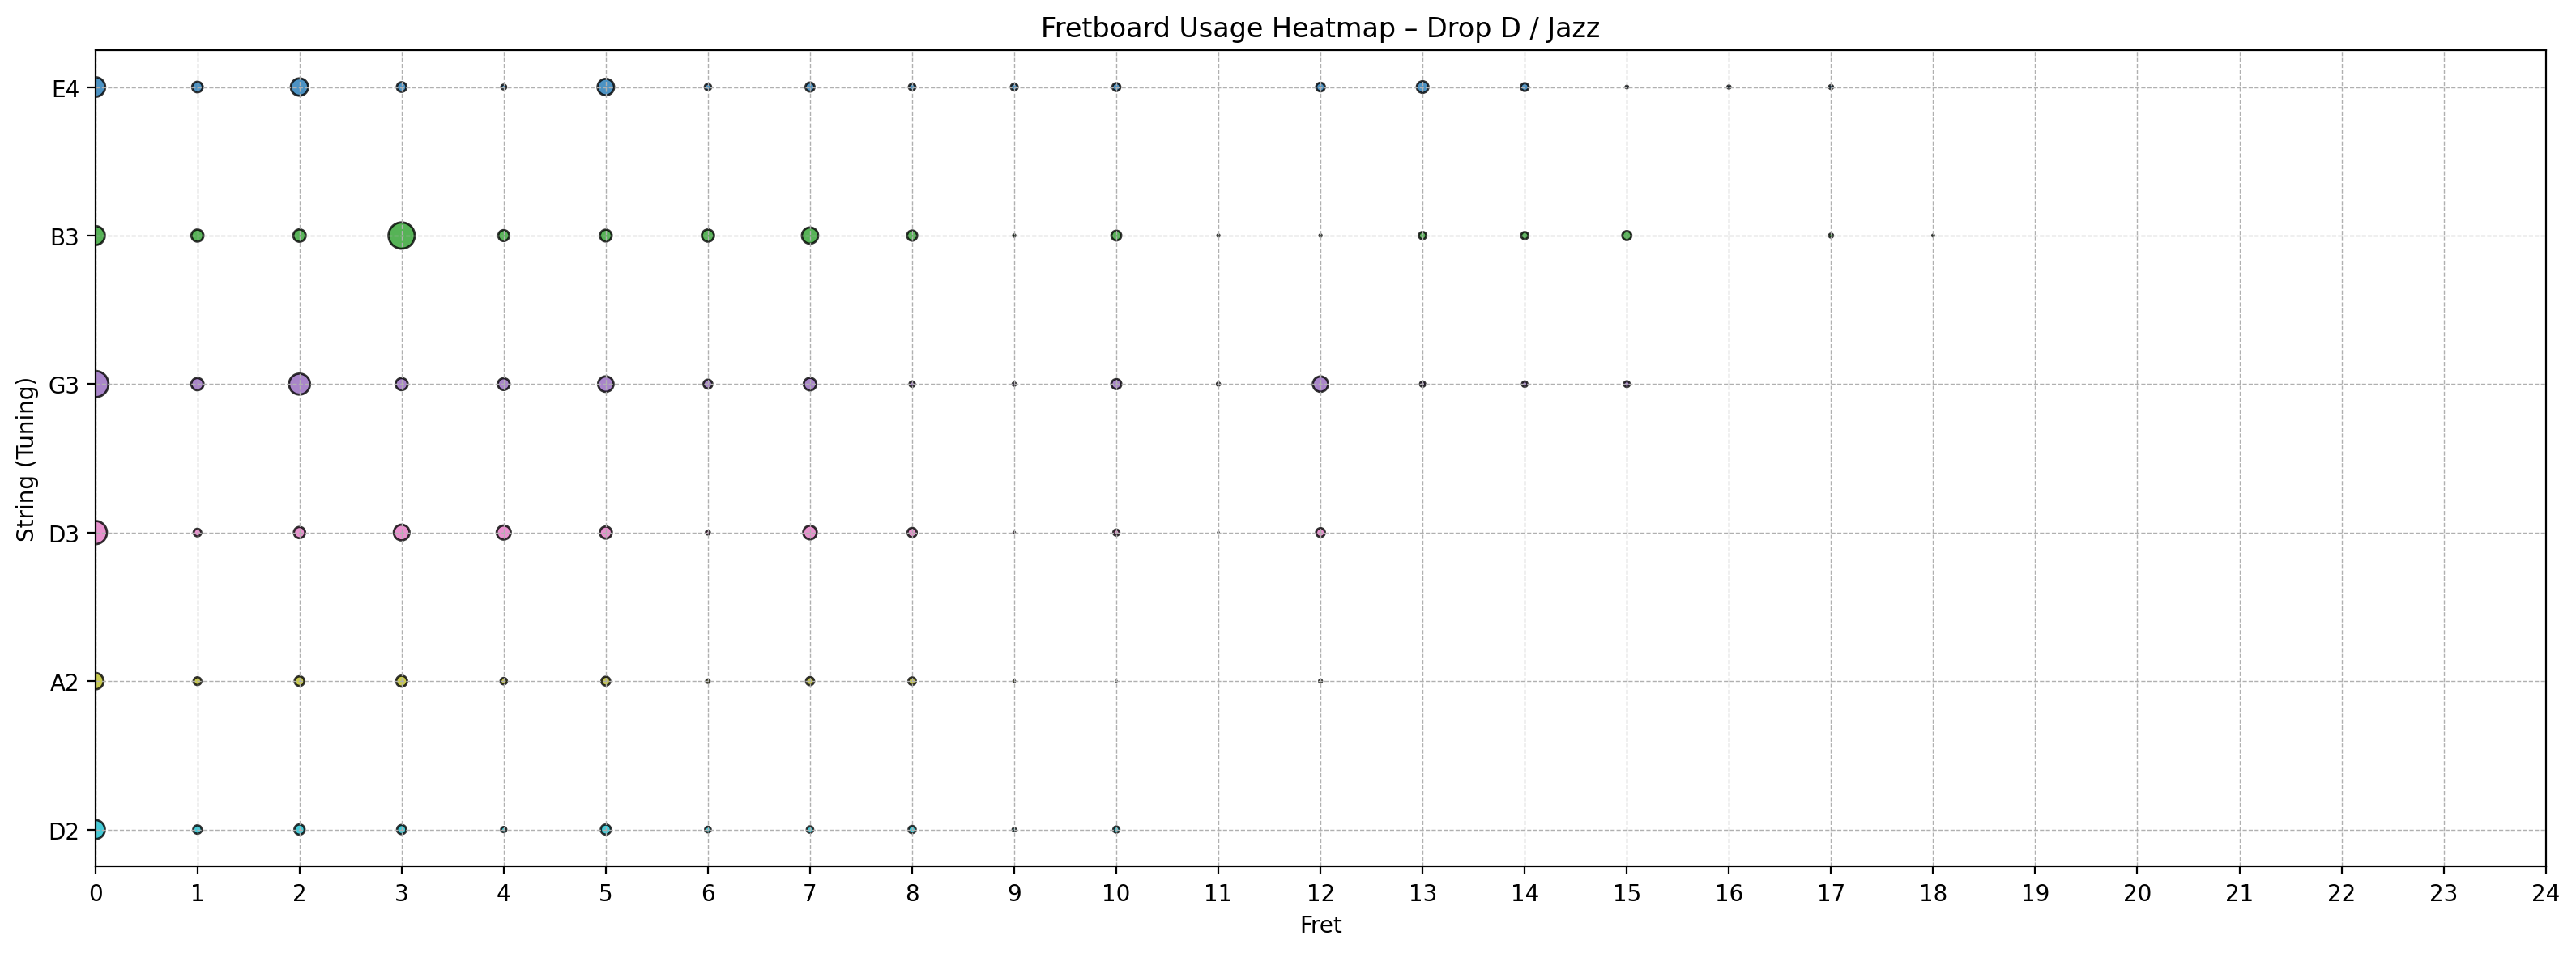

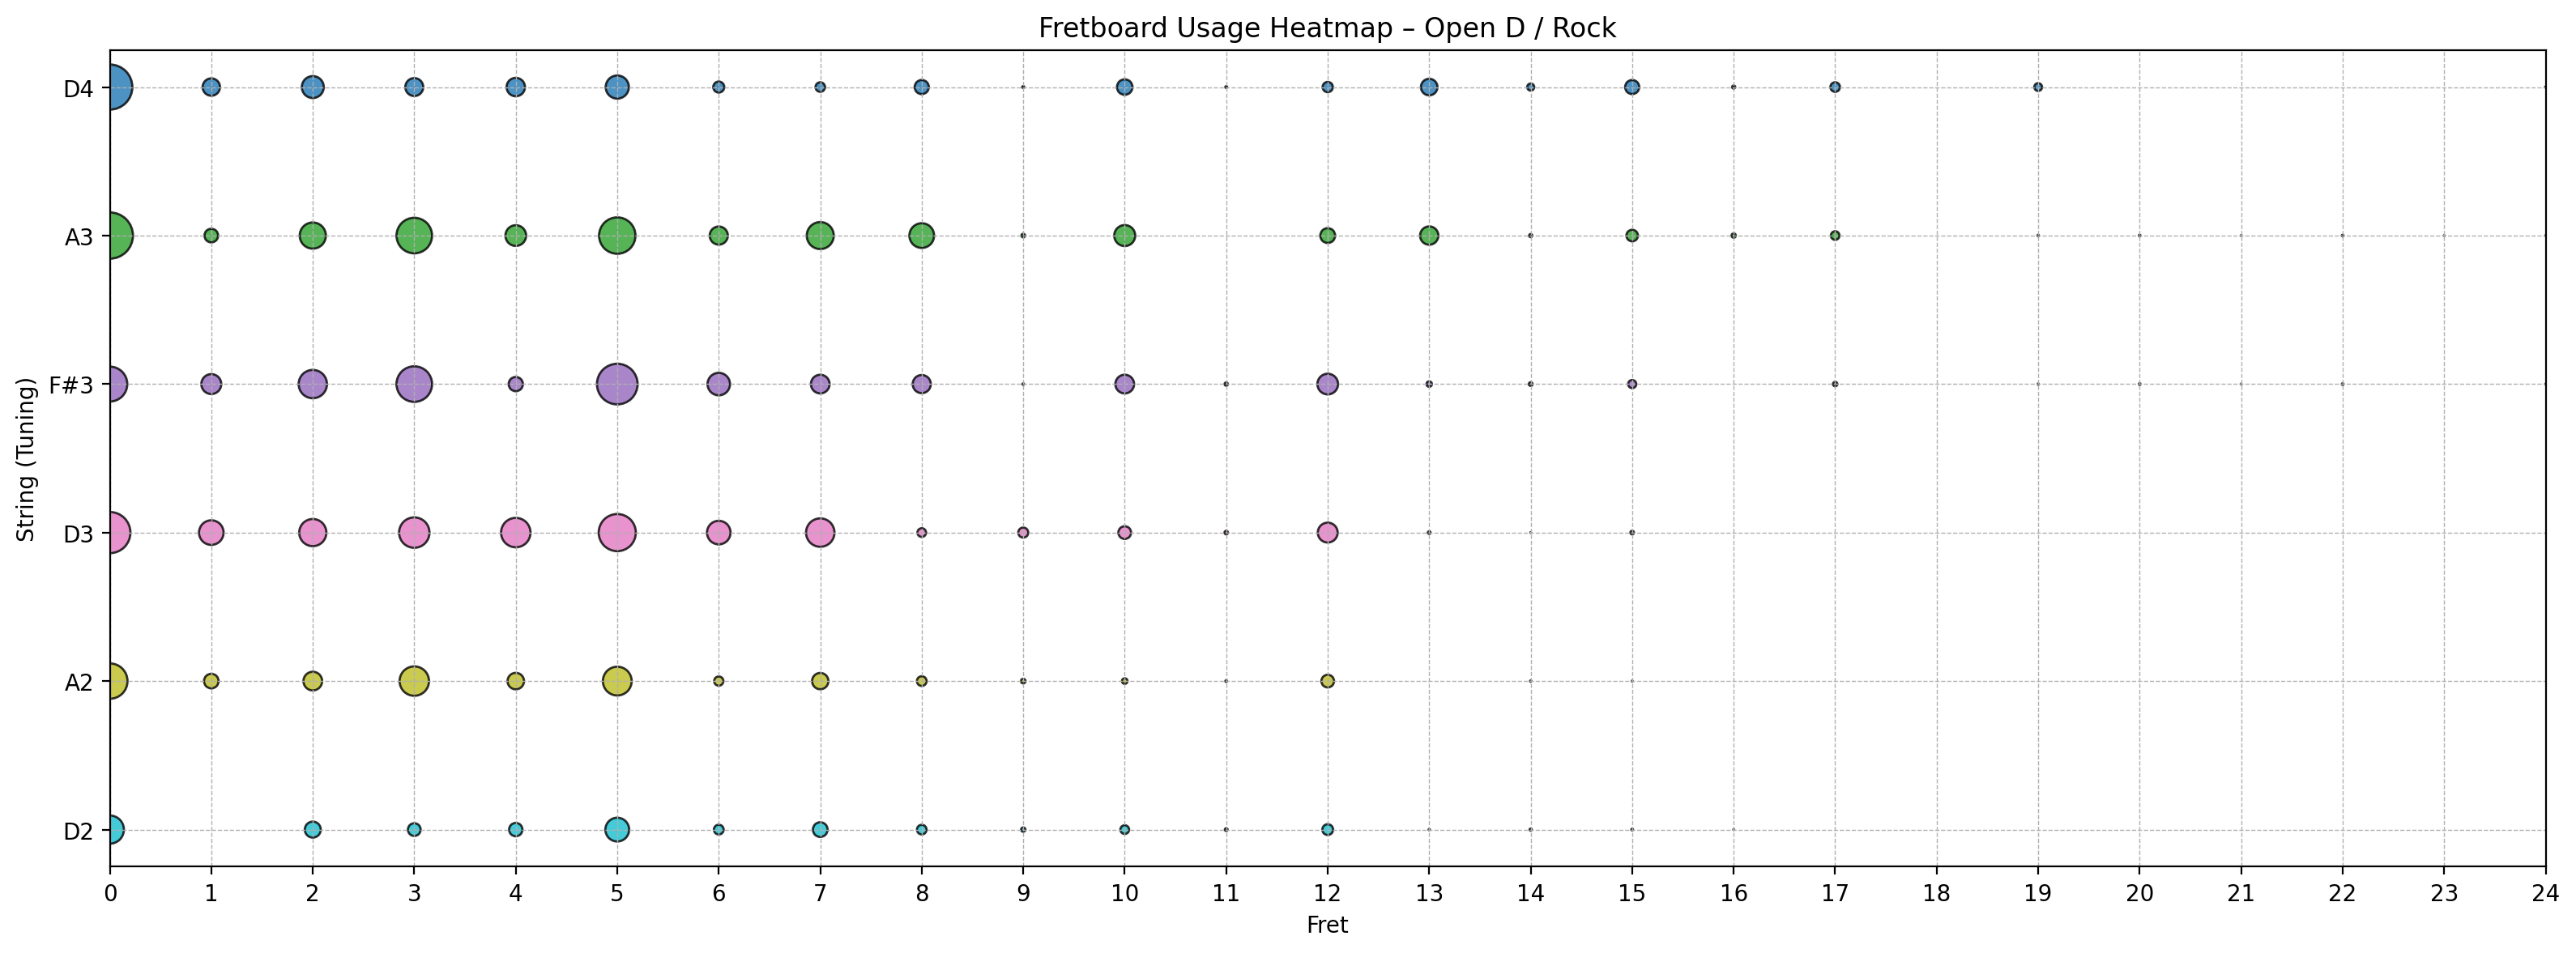

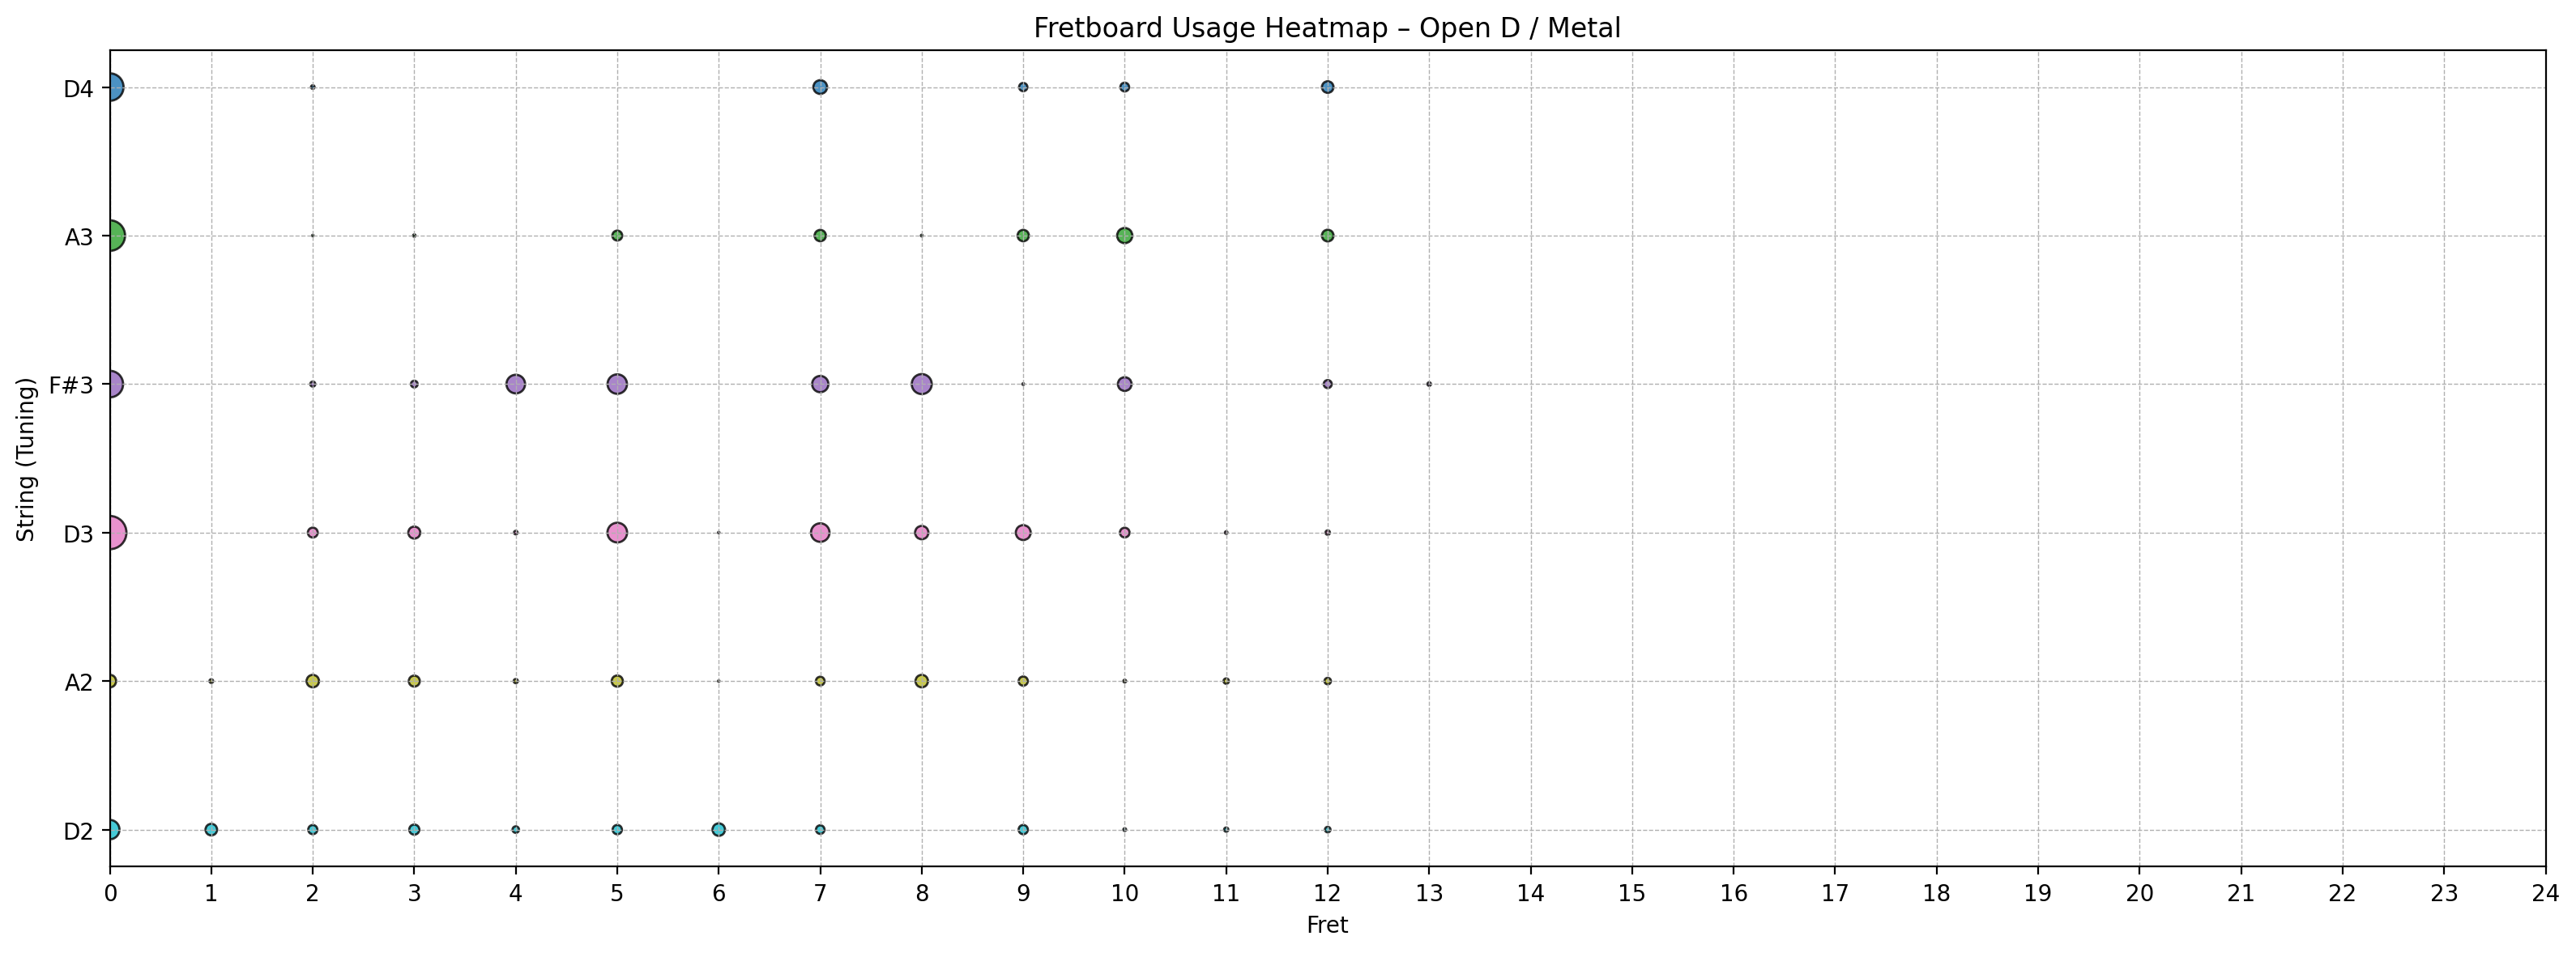

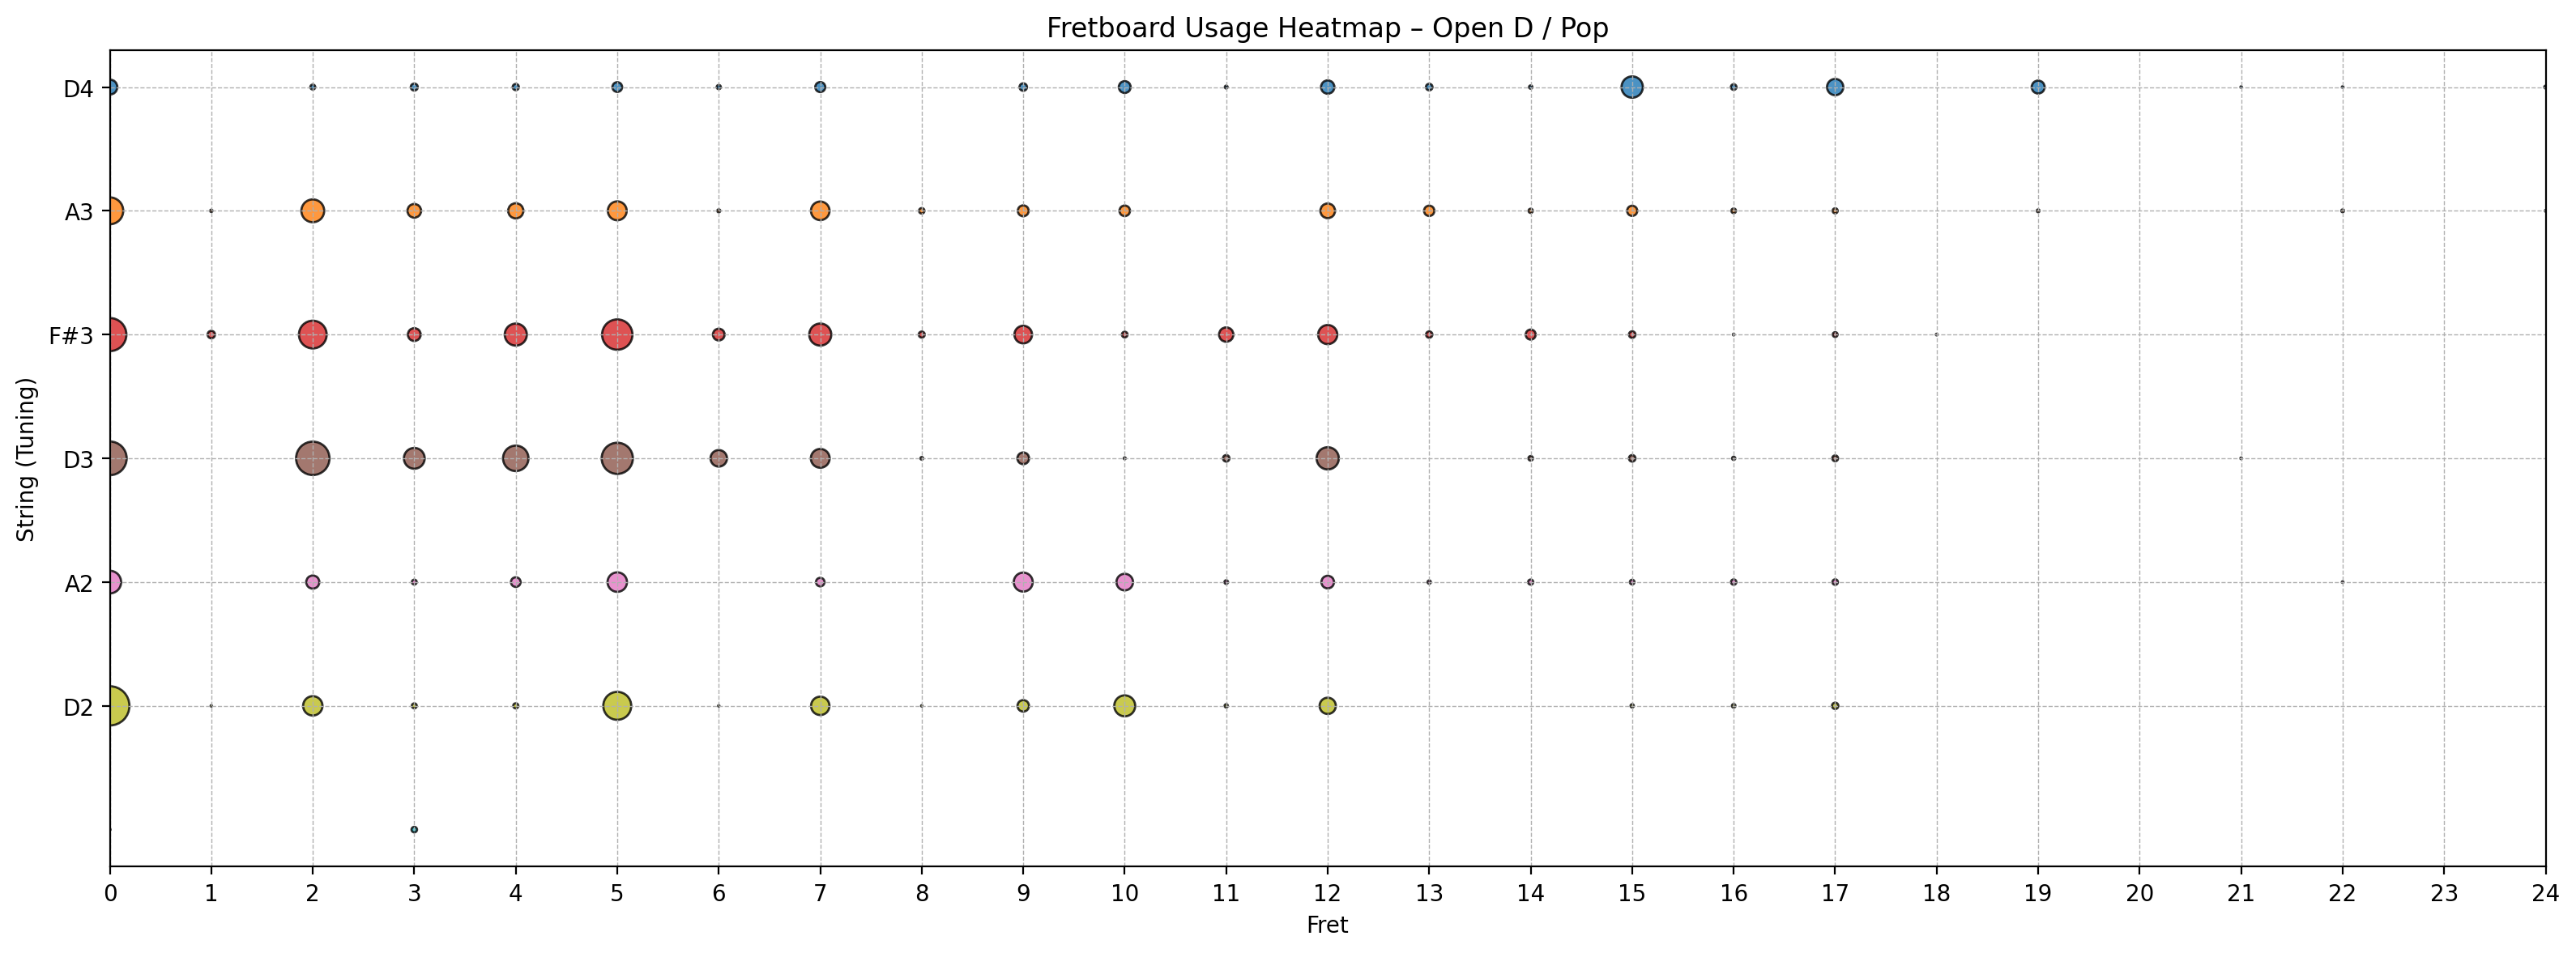

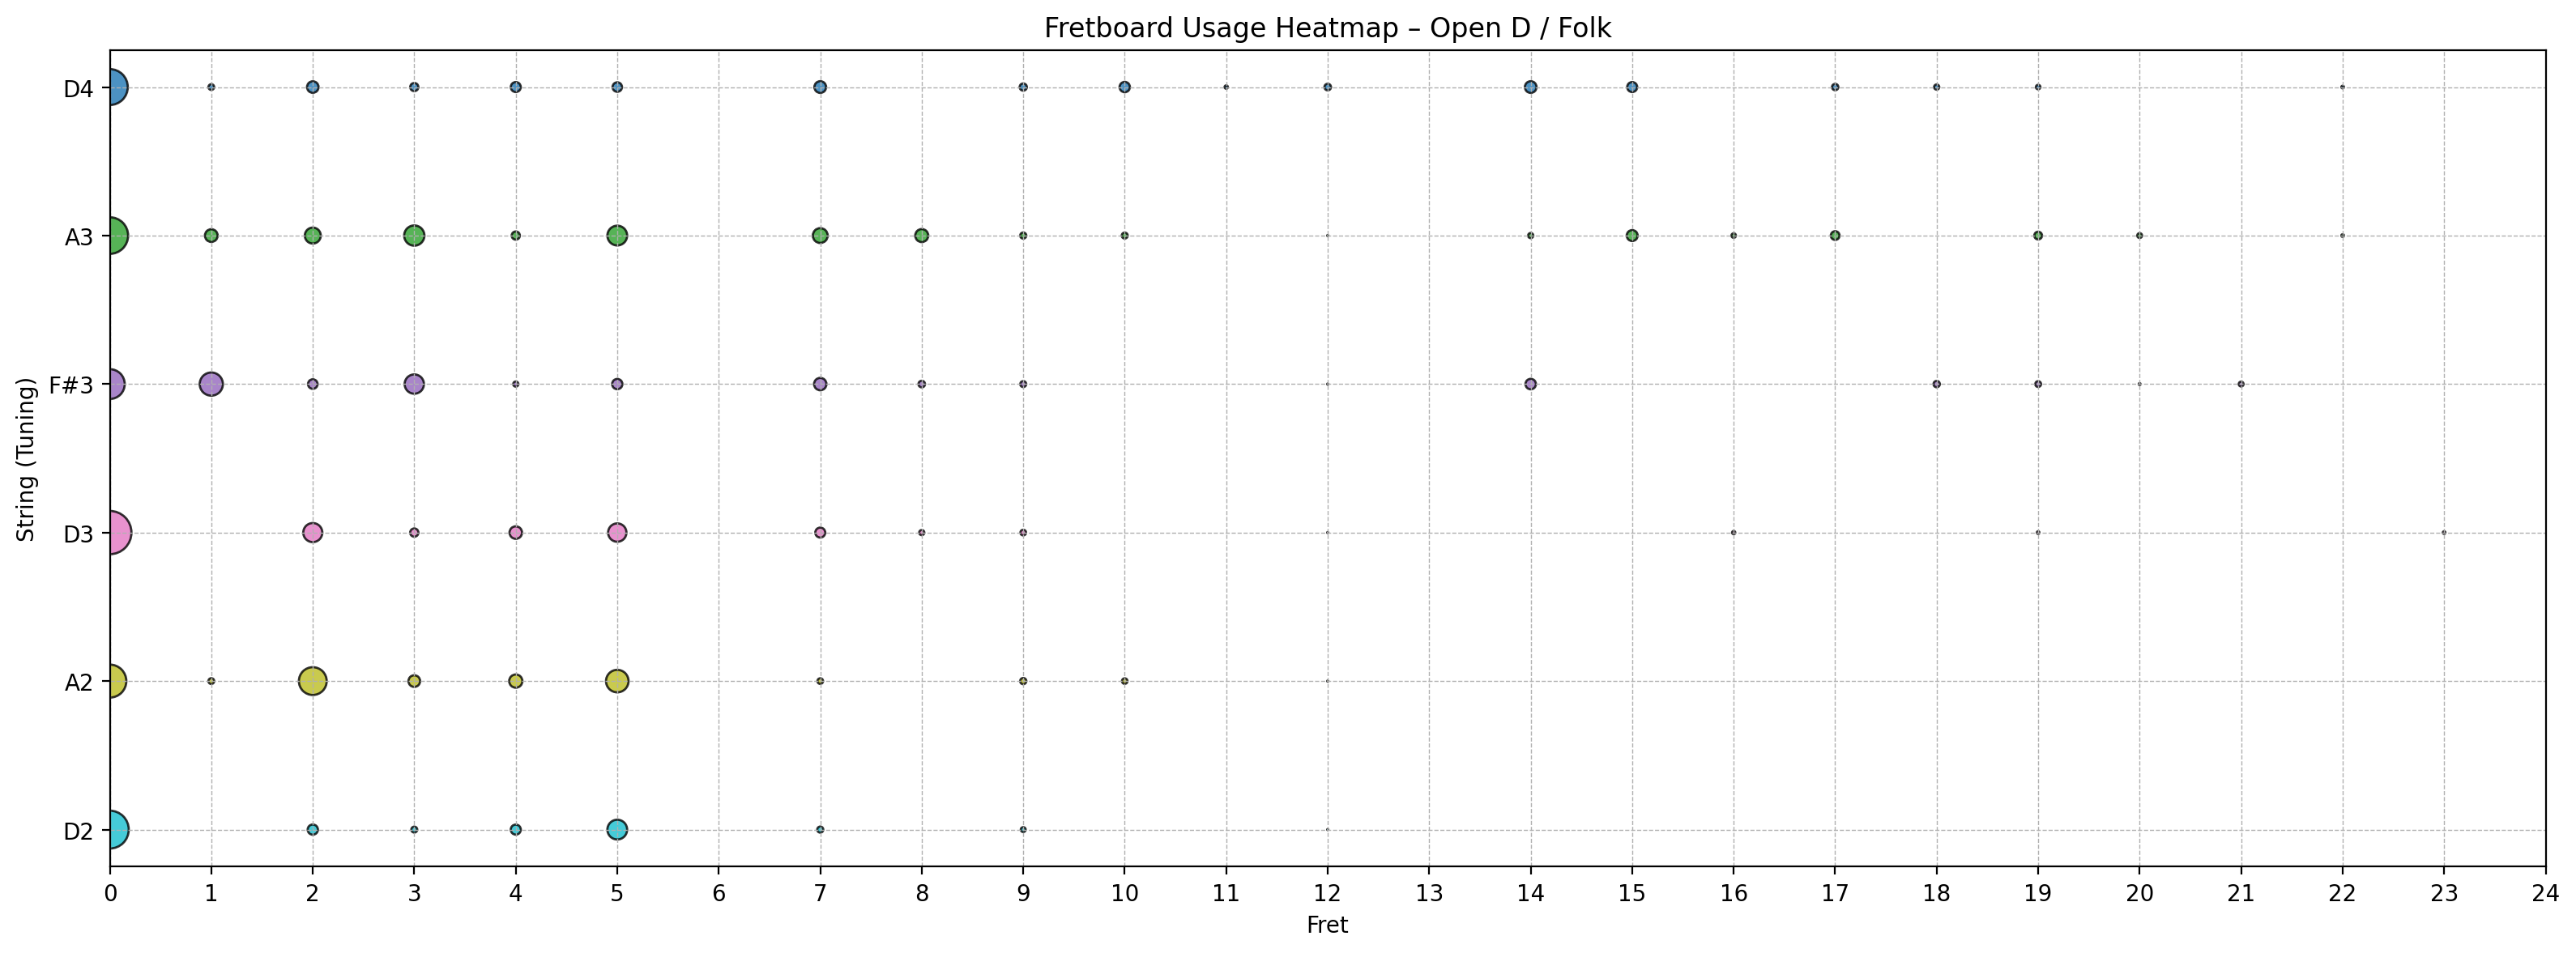

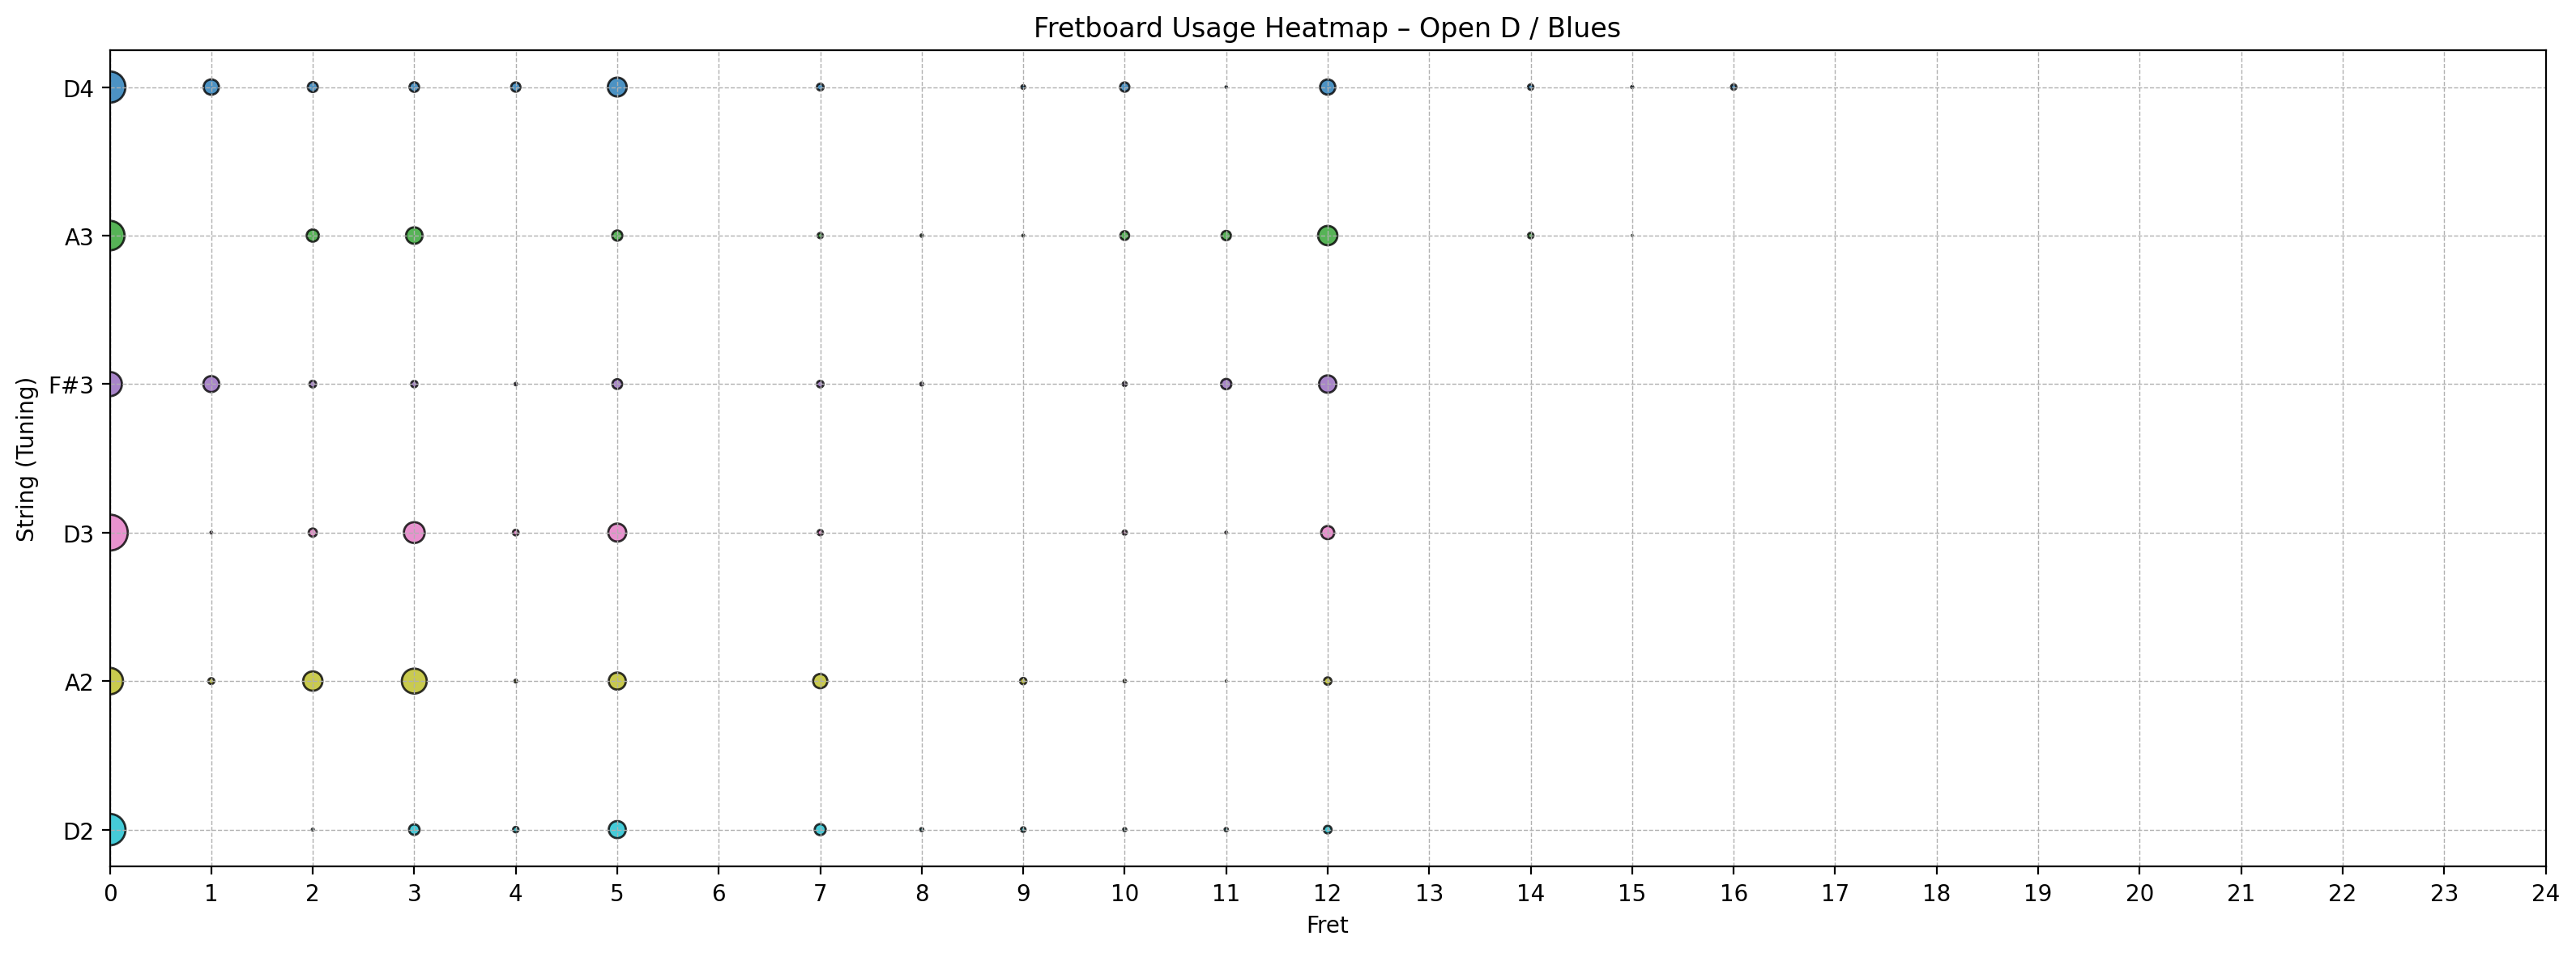

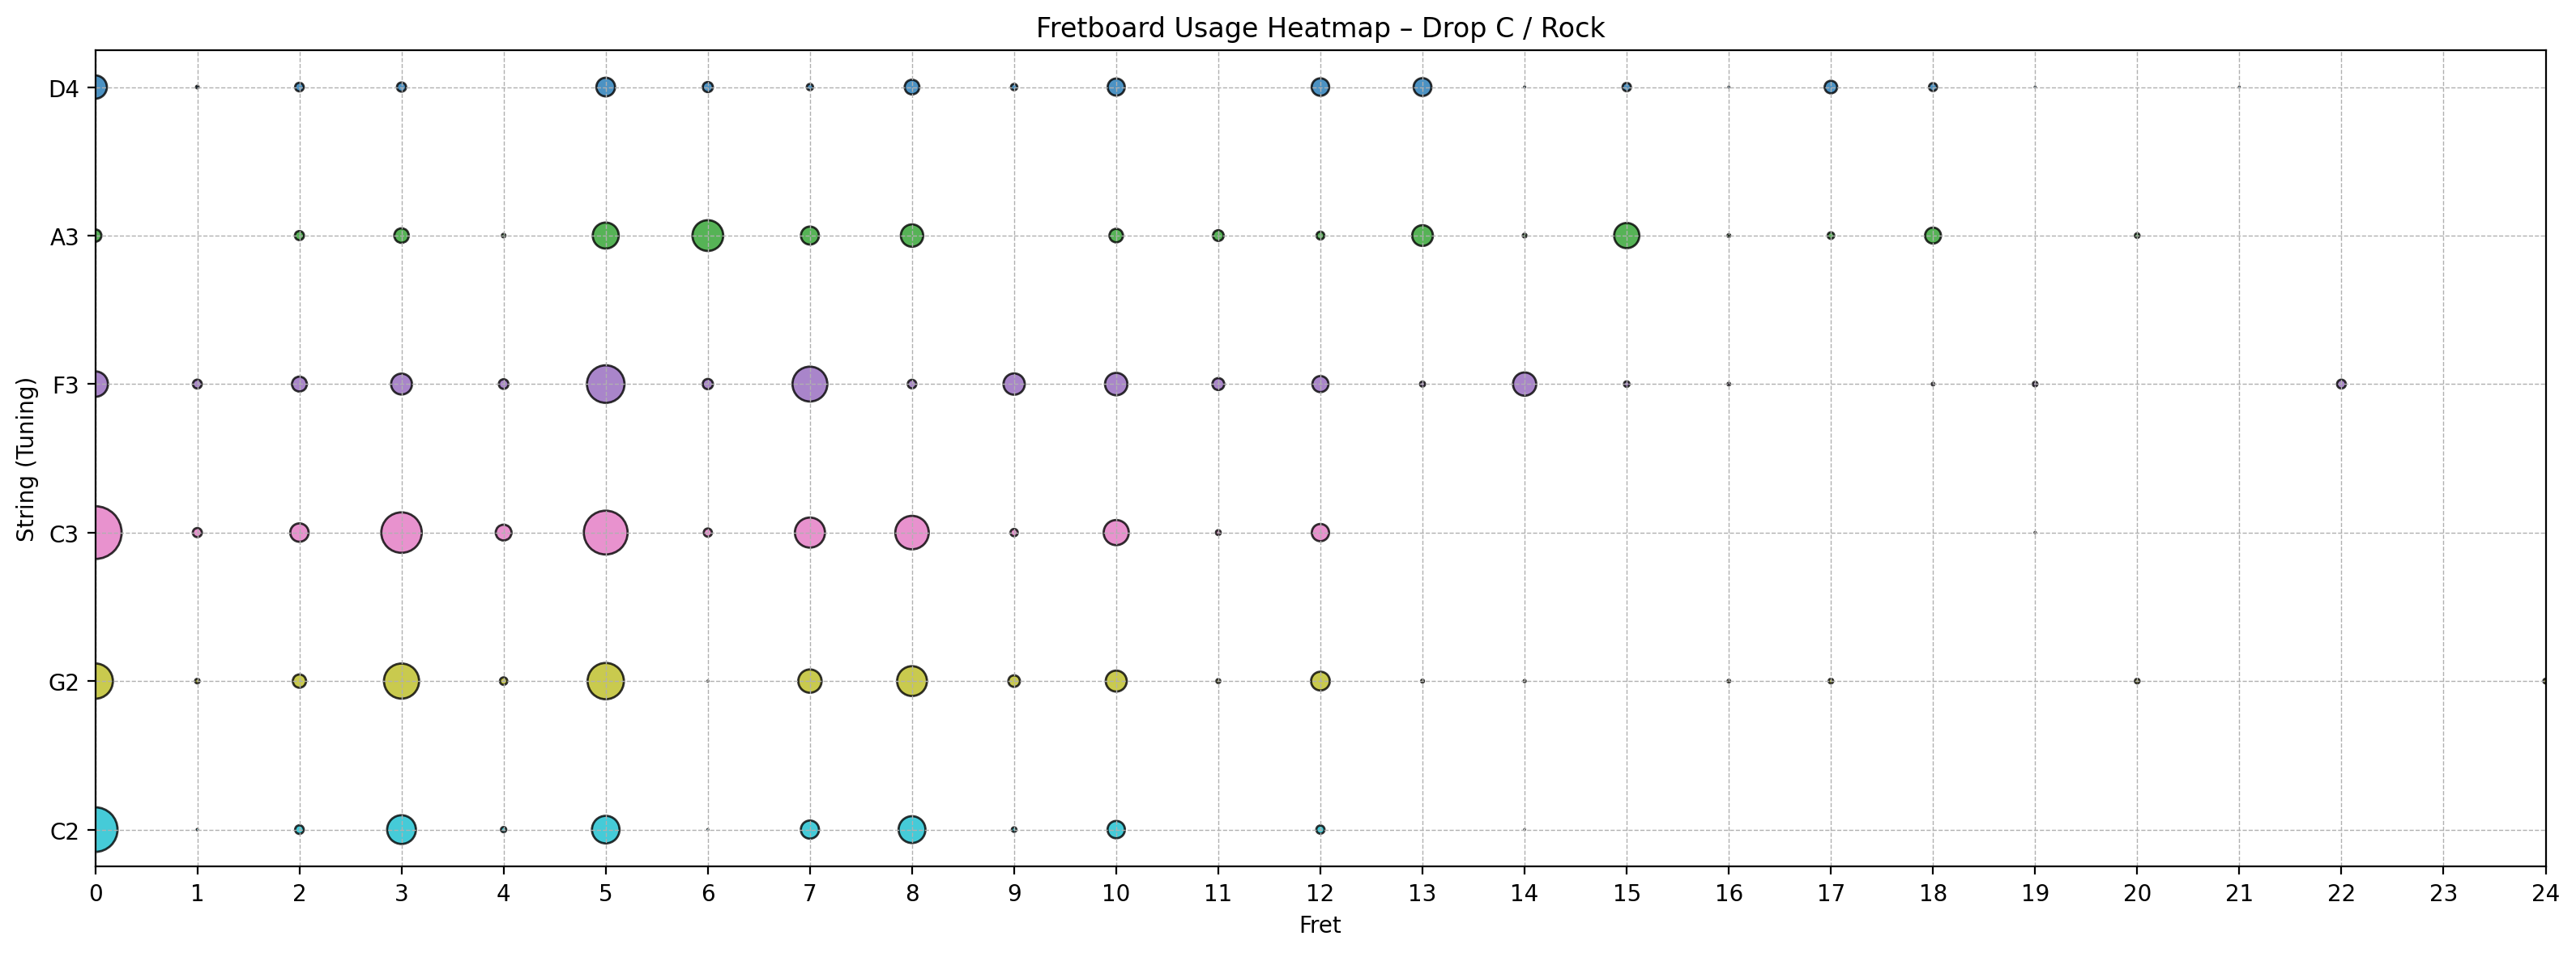

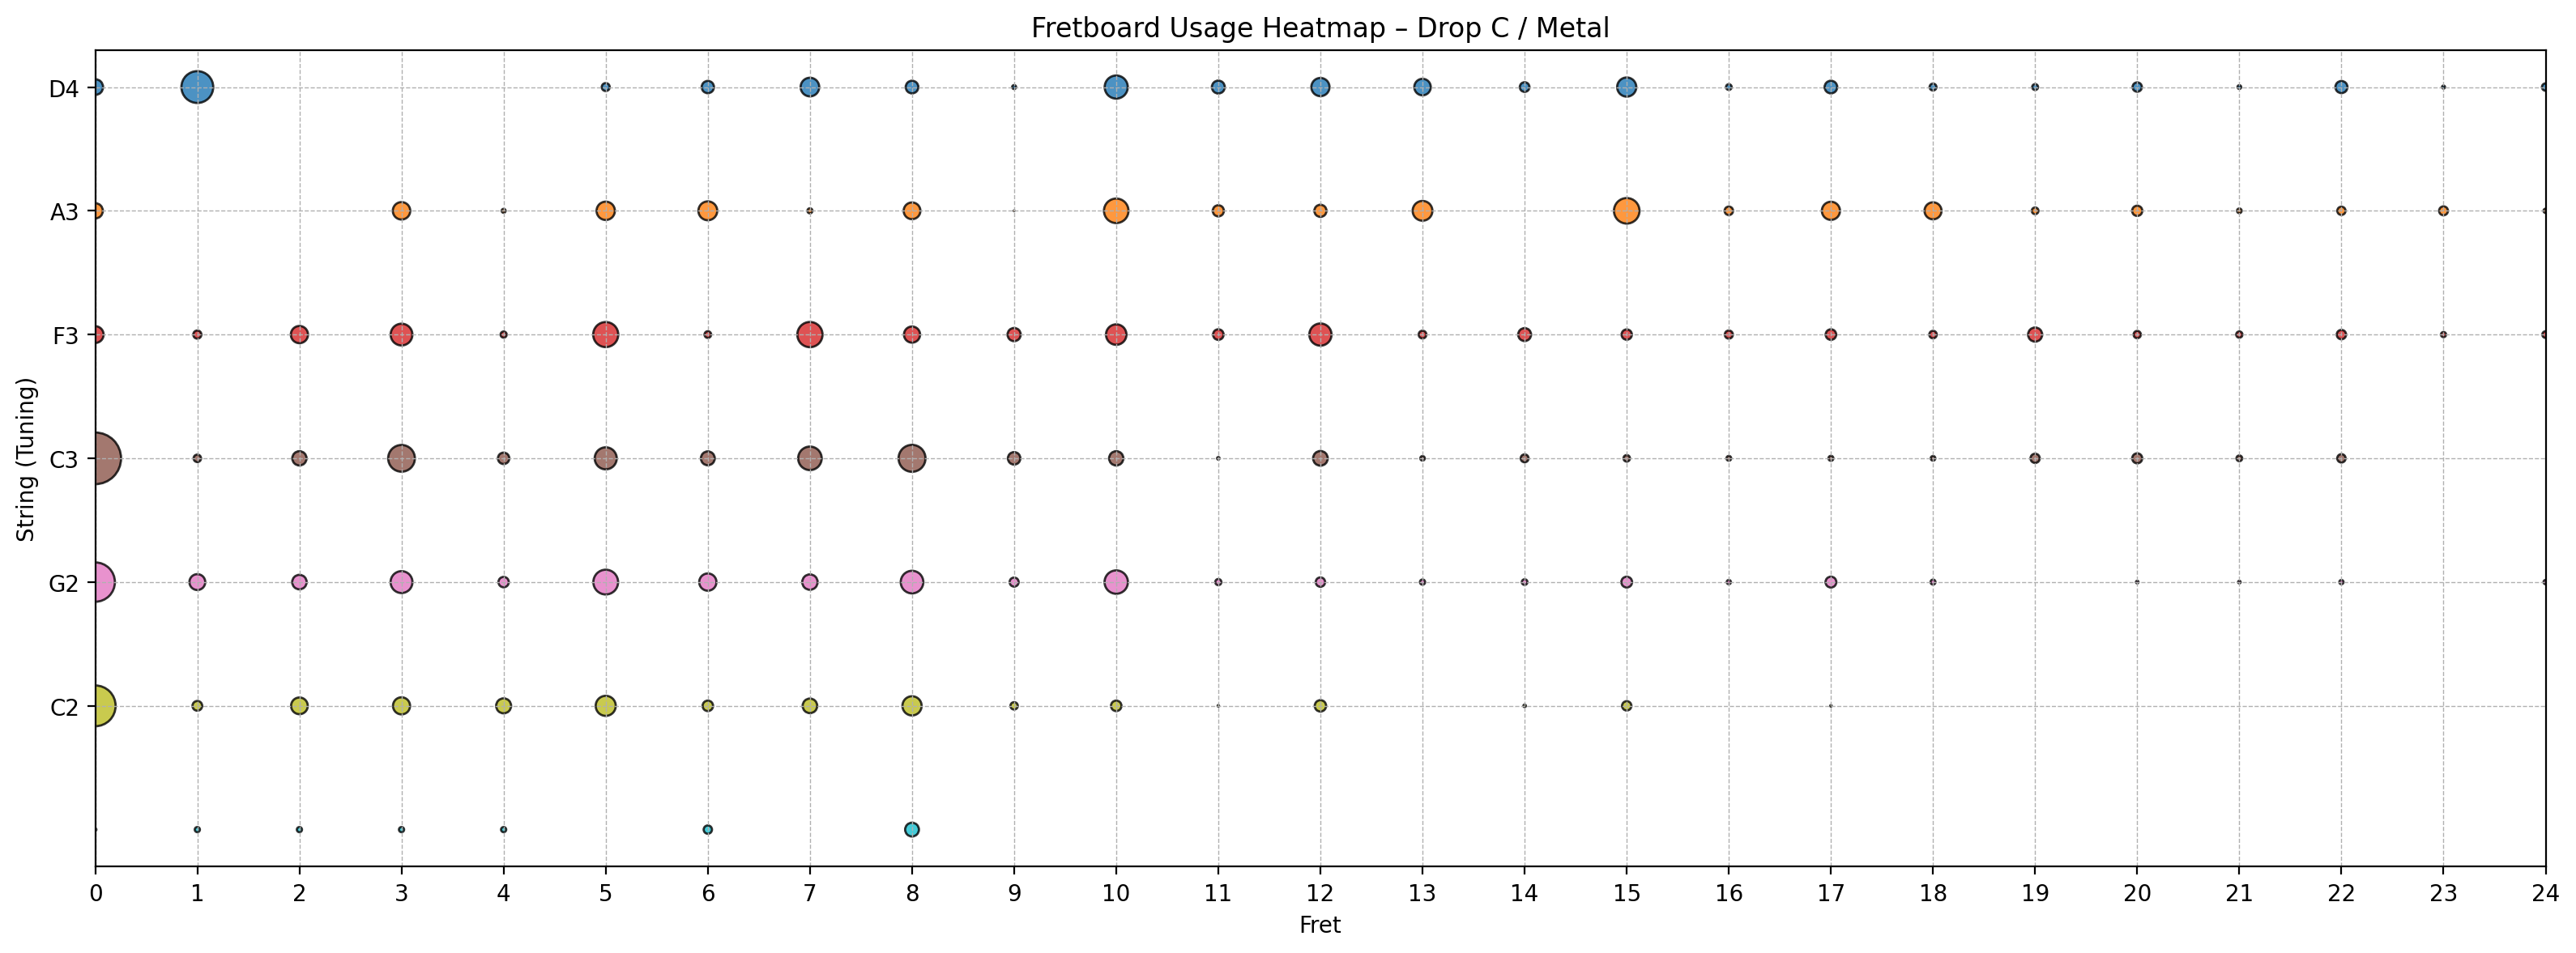

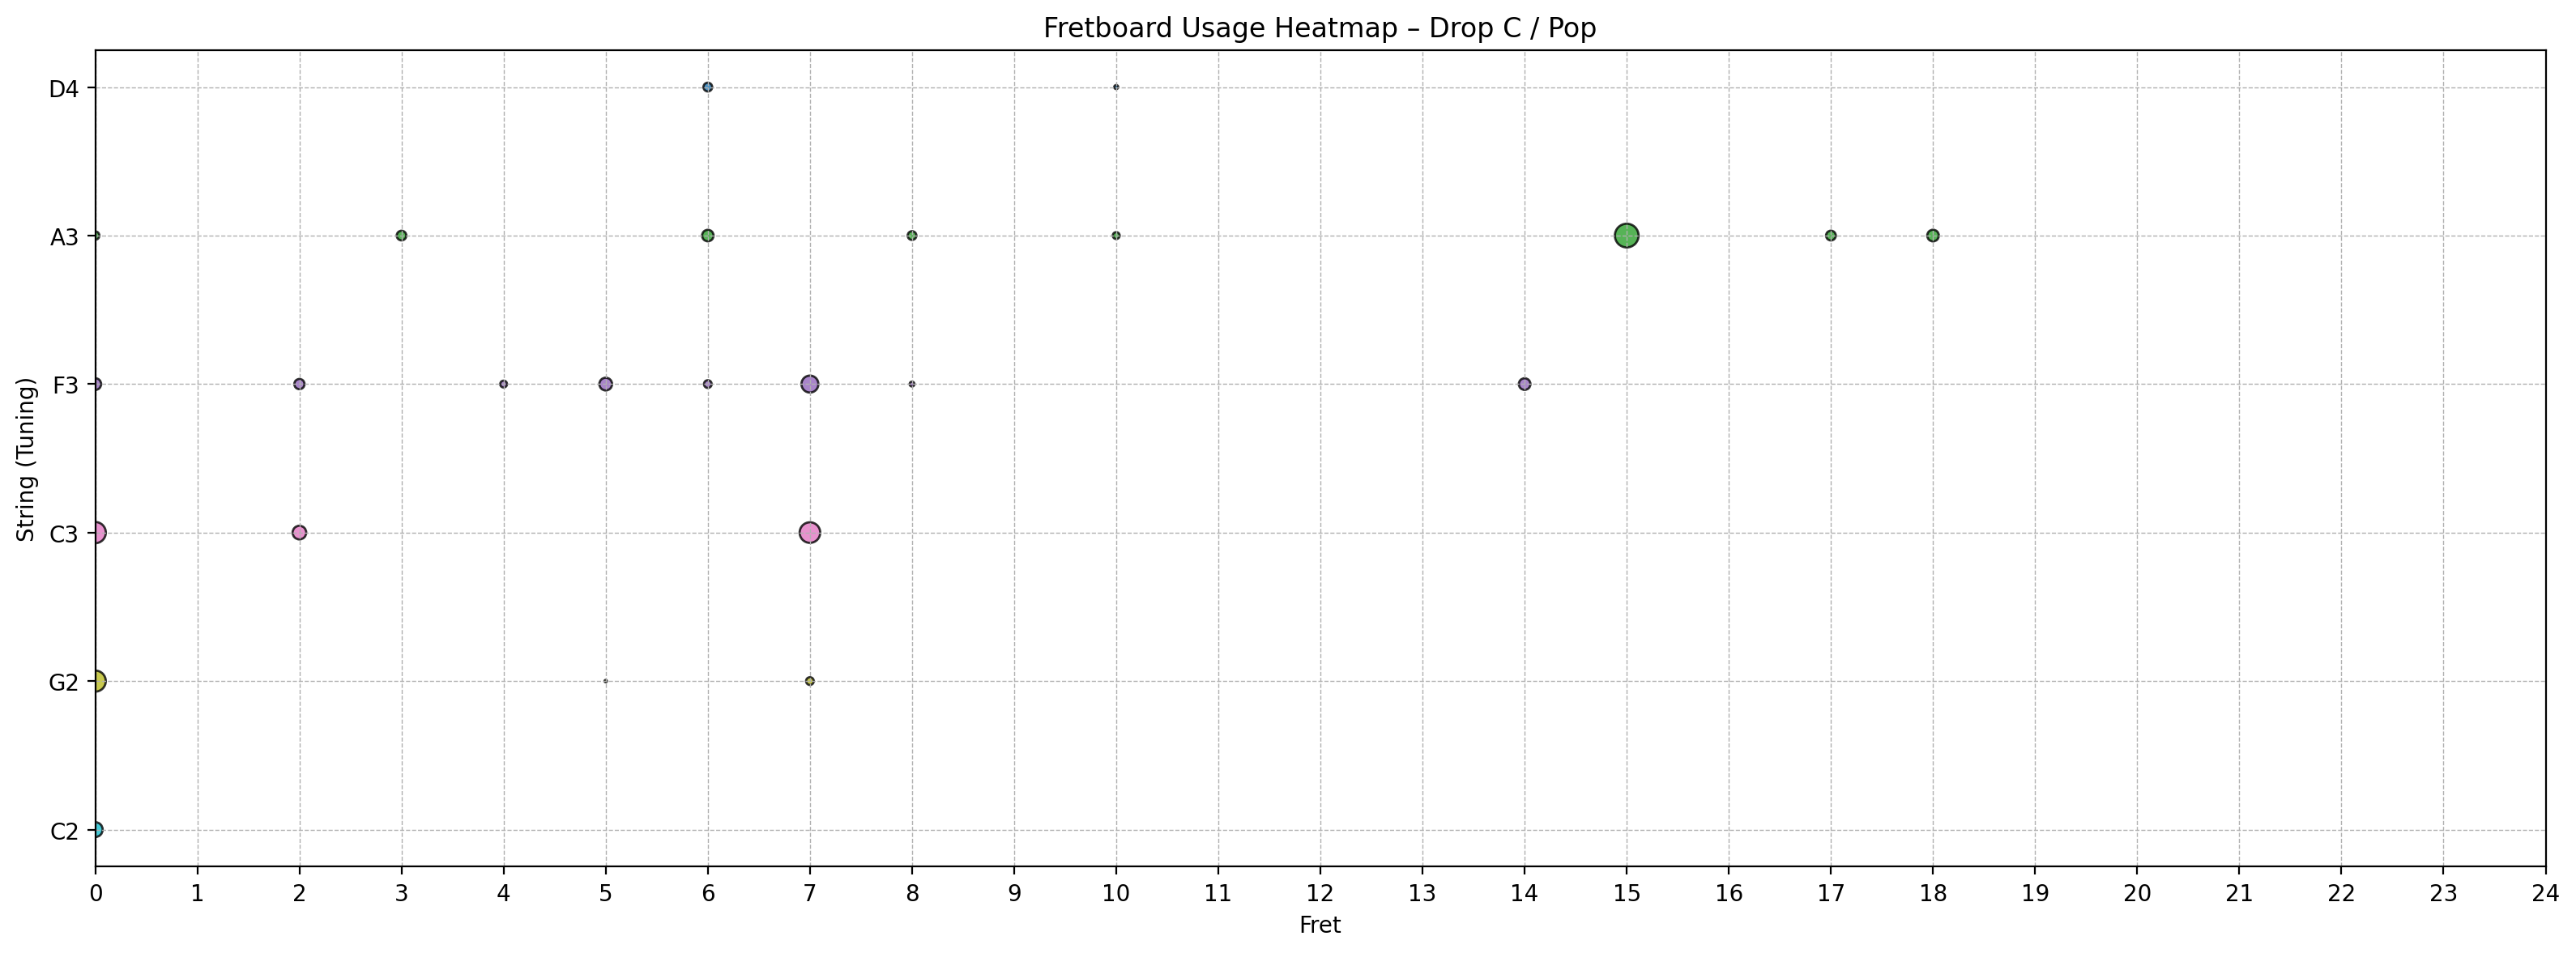

In [ ]:
import matplotlib.pyplot as plt
from music21 import pitch
from collections import defaultdict
import json

# Load the full dataset (all tunings & genres in one file)
with open("analysis_results.json") as f:
    all_tracks = json.load(f)

# Known tuning presets and genre list
TUNING_LABELS = {
    "Standard": (64, 59, 55, 50, 45, 40),
    "Drop D": (64, 59, 55, 50, 45, 38),
    "Open D": (62, 57, 54, 50, 45, 38),
    "Drop C": (62, 57, 53, 48, 43, 36),
}
GENRES = ["Rock", "Metal", "Pop", "Folk", "Blues", "Jazz"]

# Flatten all track dicts from the nested structure
flat_tracks = []
for song in all_tracks:
    for track in song.get("tracks", []):
        track["title"] = song["title"]
        track["artist"] = song.get("artist", "")
        flat_tracks.append(track)

# Iterate by (tuning, genre)
for tuning_name, tuning_midi in TUNING_LABELS.items():
    for genre in GENRES:
        matching_tracks = [
            track for track in flat_tracks
            if track.get("tuning_folder") == tuning_name and track.get("genre") == genre
        ]

        if not matching_tracks:
            continue  # Skip combos with no data

        # Aggregate fret usage
        aggregate_freq = defaultdict(float)

        for track in matching_tracks:
            freq_data = track["string_fret_frequency"]
            total_notes = sum(
                int(c)
                for fret_dict in freq_data.values()
                for c in fret_dict.values()
            )
            if total_notes == 0:
                continue

            for string_str, fret_dict in freq_data.items():
                string_num = int(string_str)
                for fret_str, count in fret_dict.items():
                    fret = int(fret_str)
                    aggregate_freq[(string_num, fret)] += (int(count) / total_notes) * 100

        # Plot data prep
        x, y, sizes, colors = [], [], [], []
        for (string_num, fret), count in aggregate_freq.items():
            x.append(fret)
            y.append(6 - string_num)
            sizes.append(count * 2)
            colors.append(string_num)

        string_labels = []
        for midi_val in reversed(tuning_midi):
            p = pitch.Pitch()
            p.midi = midi_val
            string_labels.append(p.nameWithOctave)

        # Plot
        plt.figure(figsize=(16, 6))
        plt.scatter(x, y, s=sizes, c=colors, cmap='tab10', alpha=0.8, edgecolors='k')

        plt.xlim(0, 24)
        plt.xticks(range(0, 25))
        plt.yticks(range(6), string_labels)
        plt.grid(True, linestyle='--', linewidth=0.5)
        plt.xlabel("Fret")
        plt.ylabel("String (Tuning)")
        plt.title(f"Fretboard Usage Heatmap – {tuning_name} / {genre}")
        plt.tight_layout()
        plt.show()